In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 3)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [0, 1, 7])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [0, 1, 7])
X_test, y_test = X_test[test_mask], y_test[test_mask]

# y_train과 y_test에서 7을 2로 변환
y_train = np.where(y_train == 7, 2, y_train)
y_test = np.where(y_test == 7, 2, y_test)

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [7]:
from keras.utils import to_categorical
y_train

2024-11-28 16:05:31.567123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:05:31.586637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 16:05:31.607607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 16:05:31.613988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:05:31.630656: I tensorflow/core/platform/cpu_feature_guar

array([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2,
       1, 1, 2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2,
       2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0,
       2, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1,
       1, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1,
       0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2,
       2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 0,
       2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 2, 0, 1, 0,
       2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1,
       1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2,
       2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1,
       1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1, 2, 2,

In [8]:
y_train = to_categorical(y_train, num_classes=3)

In [9]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [10]:
y_test = to_categorical(y_test, num_classes=3)

In [11]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 836, 1.0: 418}


In [12]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 242, 1.0: 121}


In [13]:
X_train.shape

(418, 8, 8)

In [14]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [15]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [16]:
# # (283, 16, 2, 2)를 (283, 16, 4)로 변환
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [17]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [18]:
X_train.shape

(418, 4, 16)

In [19]:
X_train

array([[[ 0.,  0.,  4., ...,  8., 14.,  0.],
        [ 8.,  0.,  0., ...,  4.,  8.,  0.],
        [ 0.,  8., 12., ...,  0.,  7., 15.],
        [ 0.,  4.,  8., ...,  2.,  0.,  0.]],

       [[ 0.,  0.,  3., ...,  0.,  0.,  0.],
        [16., 16., 13., ..., 11.,  1.,  0.],
        [ 0.,  0.,  2., ...,  0.,  2., 15.],
        [15., 16.,  9., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  4., ...,  0.,  1.,  9.],
        [16., 11.,  0., ..., 16., 10.,  0.],
        [ 0.,  0., 13., ...,  0.,  6., 11.],
        [16.,  8.,  2., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  3., 15., ...,  0., 11., 13.],
        [15.,  3.,  0., ..., 16.,  8.,  0.],
        [ 0.,  1., 15., ...,  3., 16.,  5.],
        [15.,  7.,  2., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  7., 12.,  0.],
        [16., 10.,  0., ..., 11.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  1., 15.],
        [15., 16.,  7., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  1., ...,  0.,  9., 16.],
        [11.,  1.,  0., ...,  0.

In [20]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(4, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [21]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([4, 12])
Number of parameters: 48
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([4, 12])
Number of parameters: 48
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([4, 12])
Number of parameters: 48
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([3, 64])
Number of parameters: 192
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([3])
Number of parameters: 3
--------------------------------------------------
Total number of trainable parameters: 339


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 4, 16])
Row sums: [2.917362  2.879971  2.404743  1.3987527]


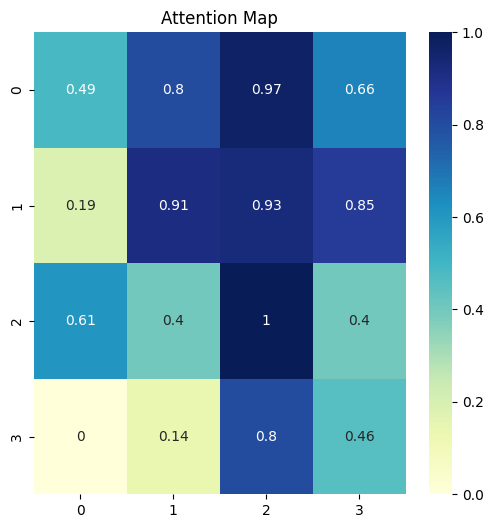

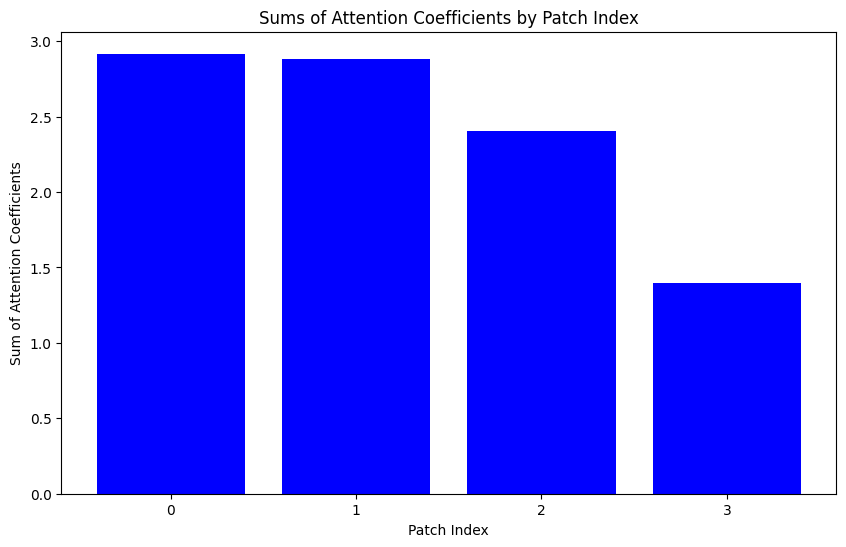

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1                [-1, 4, 16]               0
   QSANN_pennylane-2                [-1, 4, 16]               0
            Linear-3                    [-1, 3]             195
Total params: 195
Trainable params: 195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [22]:
from torchsummary import summary
summary(model, input_size=(4, 16))  # (sequence_length, embed_size)


In [25]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([418, 4, 16])
Row sums: [3.3503017 1.8448521 1.6358817 1.5244143]


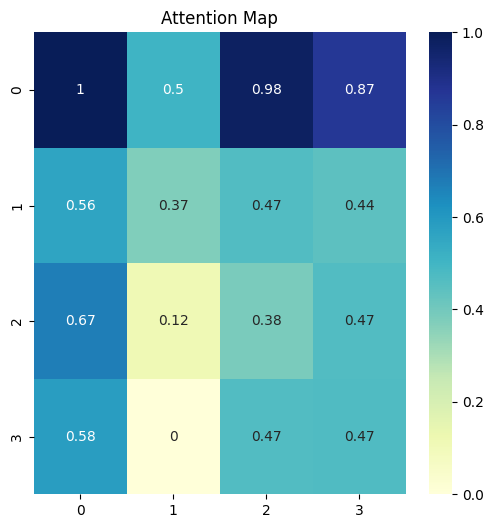

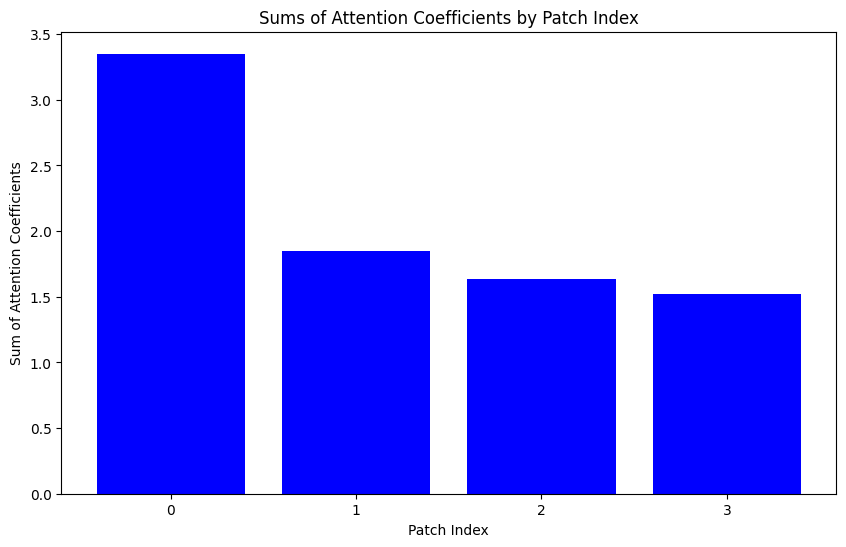

tensor([1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,
        2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1,
        2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2,
        0, 1, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2,
        2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1,
        0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2,
        2, 1, 1, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2,
        2, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 1, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1,
        2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2,
        2, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2,

/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  1%|          | 1/100 [02:56<4:51:38, 176.75s/it]

torch.Size([418, 4, 16])
Row sums: [3.3839529 1.8405958 1.6717379 1.5326803]


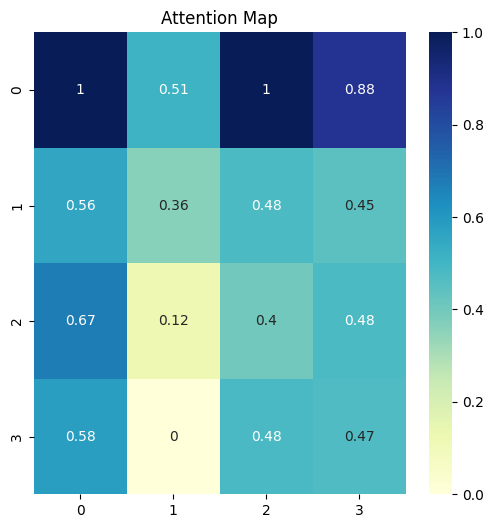

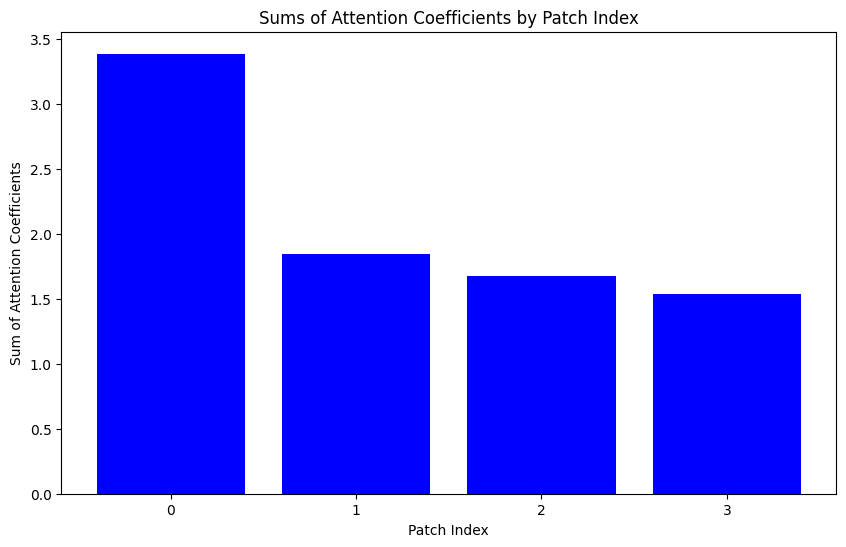

tensor([0, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2,
        2, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0,
        2, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
        0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2,
        2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
        2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2,
        2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2,
        2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2,

  2%|▏         | 2/100 [06:10<5:04:54, 186.68s/it]

torch.Size([418, 4, 16])
Row sums: [3.3612432 1.8310419 1.6770997 1.514919 ]


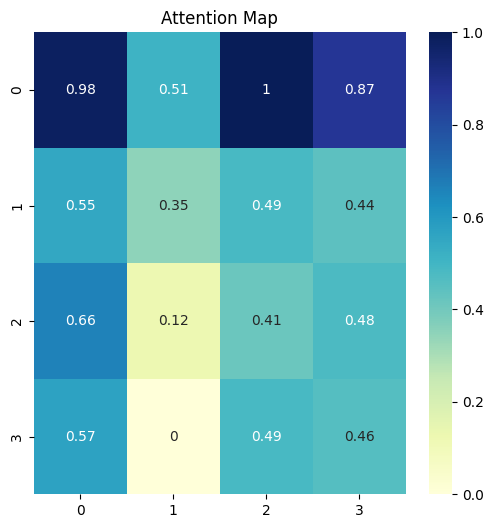

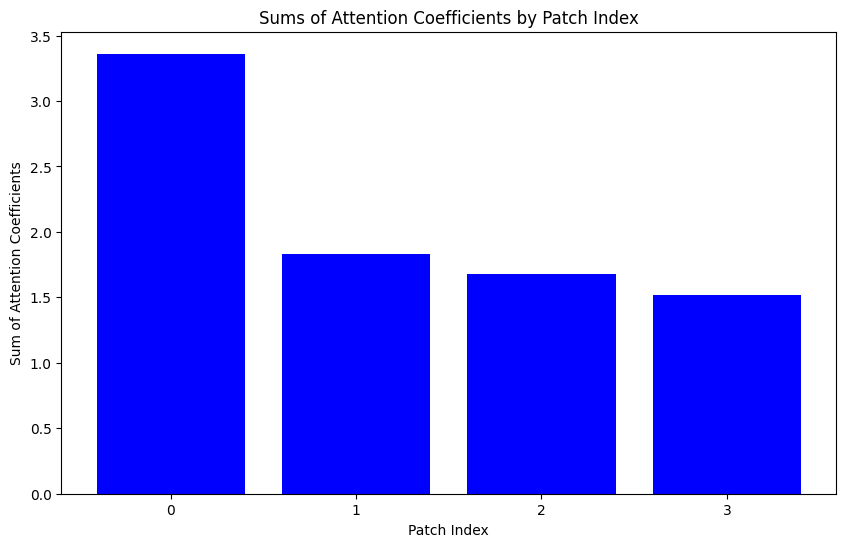

tensor([0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 1, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0,
        2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2,
        2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0,
        0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
        2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0,
        2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2,
        2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2,
        2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0,

  3%|▎         | 3/100 [09:21<5:04:48, 188.54s/it]

torch.Size([418, 4, 16])
Row sums: [3.3358746 1.8268489 1.6741954 1.4976058]


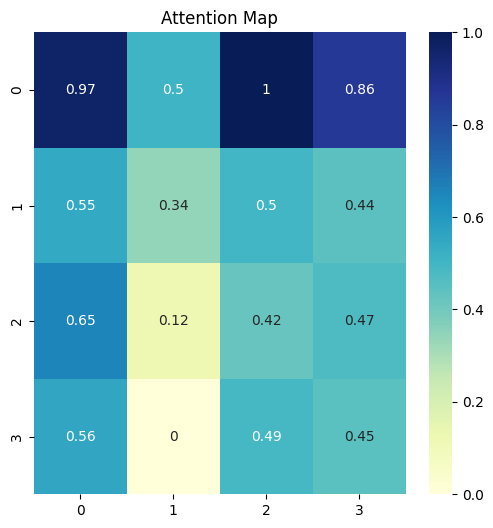

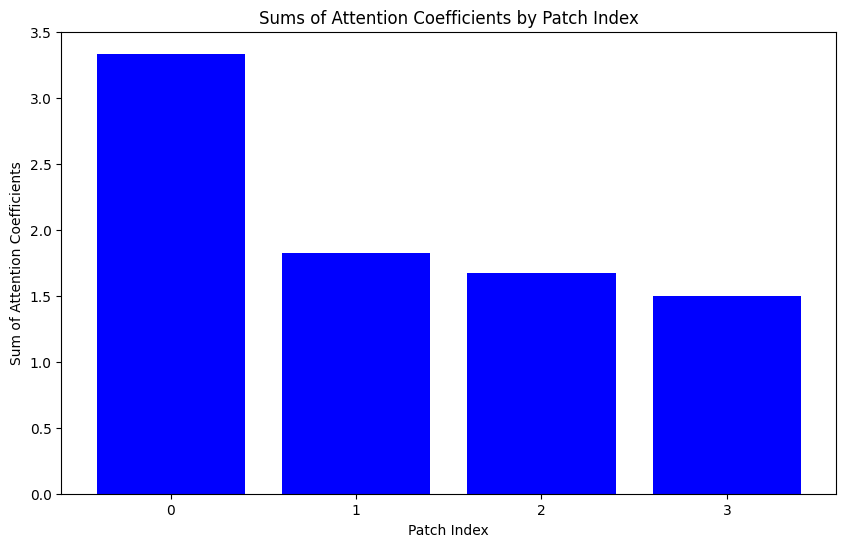

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0,
        2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0,
        2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2,
        1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1,
        2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0,
        2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0, 2,
        2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2,
        2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0,

  4%|▍         | 4/100 [12:12<4:50:45, 181.73s/it]

torch.Size([418, 4, 16])
Row sums: [3.318291  1.8243303 1.6683934 1.4820032]


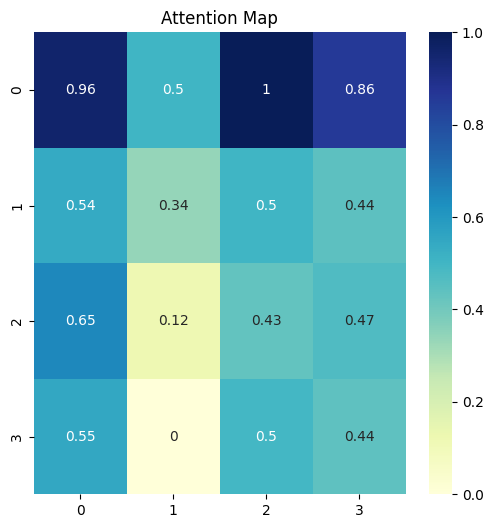

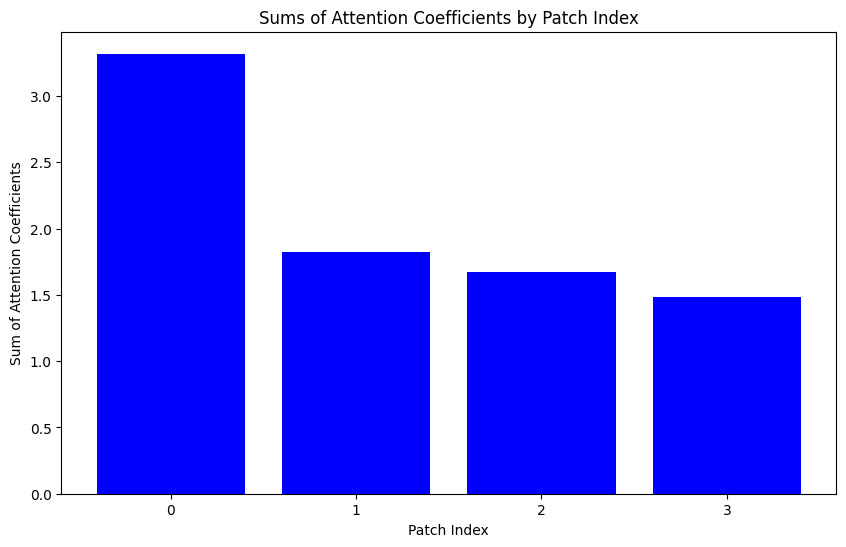

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2,
        1, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 0,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1,
        2, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0,
        1, 1, 0, 0, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

  5%|▌         | 5/100 [14:57<4:38:16, 175.76s/it]

torch.Size([418, 4, 16])
Row sums: [3.3062077 1.8232127 1.6675372 1.4689432]


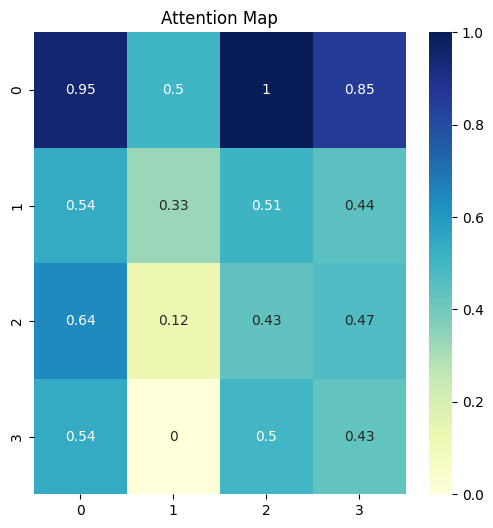

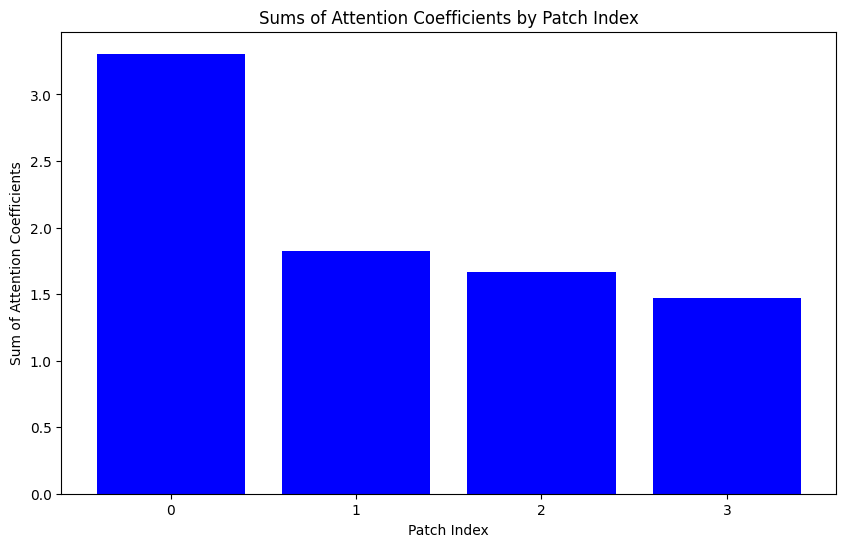

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0, 0,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2,
        1, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 0,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        2, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 0, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

  6%|▌         | 6/100 [17:46<4:31:33, 173.34s/it]

torch.Size([418, 4, 16])
Row sums: [3.3052032 1.8298638 1.6738126 1.4581859]


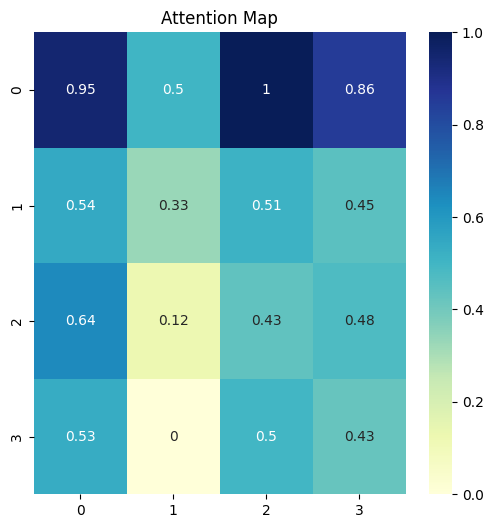

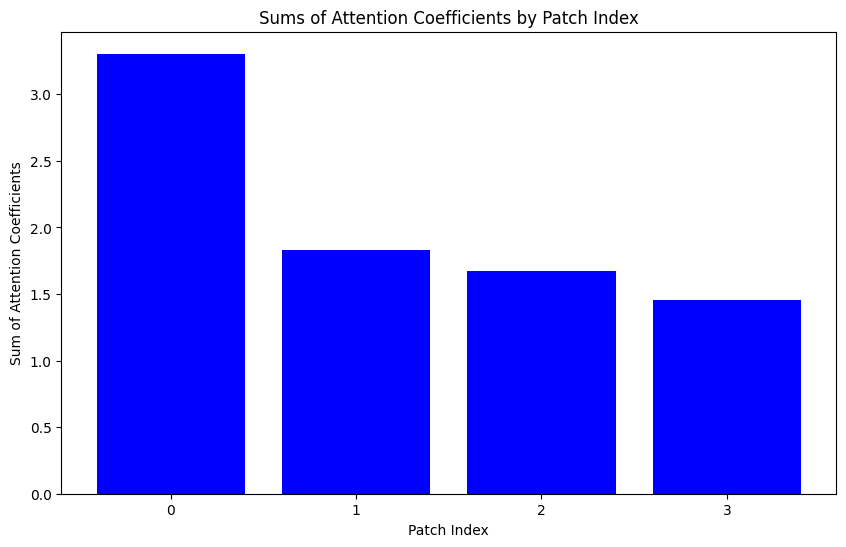

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 0, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 0,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

  7%|▋         | 7/100 [20:30<4:24:07, 170.40s/it]

torch.Size([418, 4, 16])
Row sums: [3.3123286 1.8391384 1.6830027 1.4505557]


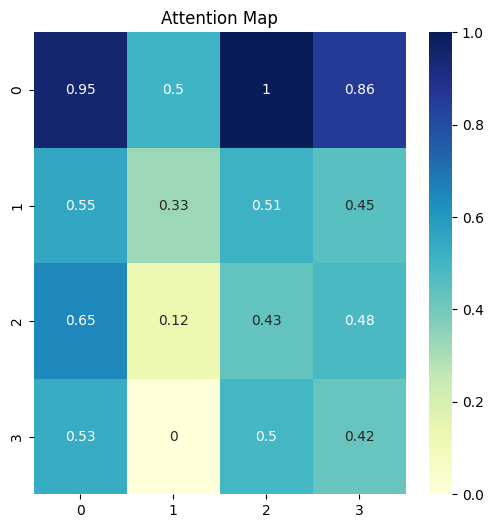

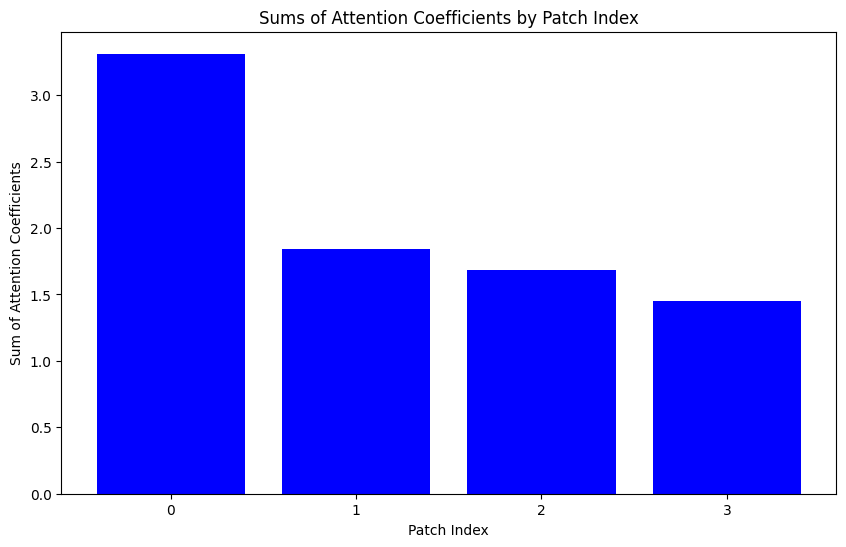

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

  8%|▊         | 8/100 [23:20<4:20:58, 170.20s/it]

torch.Size([418, 4, 16])
Row sums: [3.323139  1.8458393 1.688787  1.4476261]


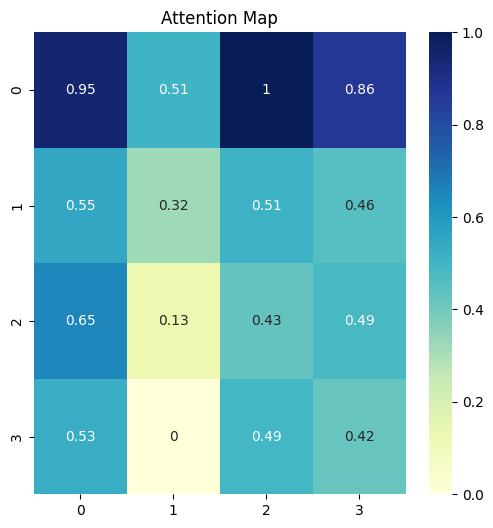

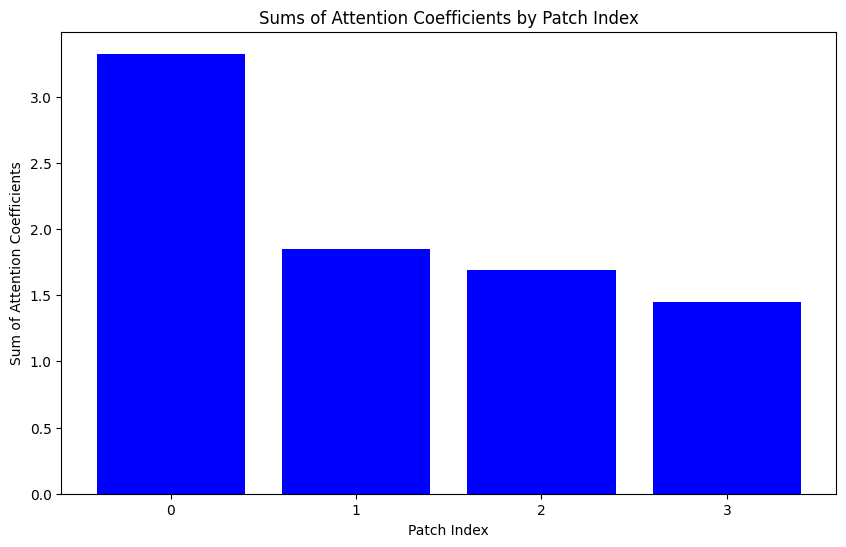

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

  9%|▉         | 9/100 [26:12<4:19:06, 170.84s/it]

torch.Size([418, 4, 16])
Row sums: [3.3362675 1.8498954 1.6899384 1.4487251]


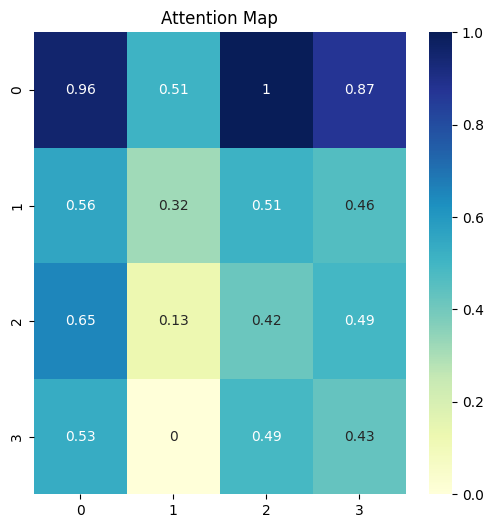

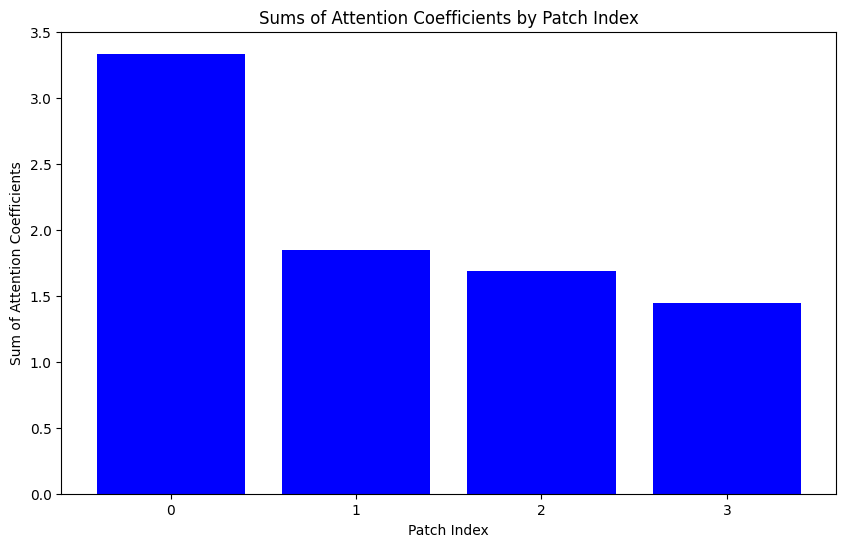

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 10%|█         | 10/100 [29:00<4:14:56, 169.96s/it]

torch.Size([418, 4, 16])
Row sums: [3.3516686 1.8532153 1.6884712 1.4520545]


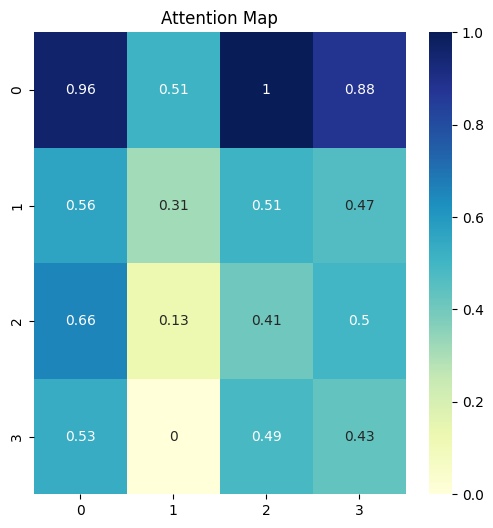

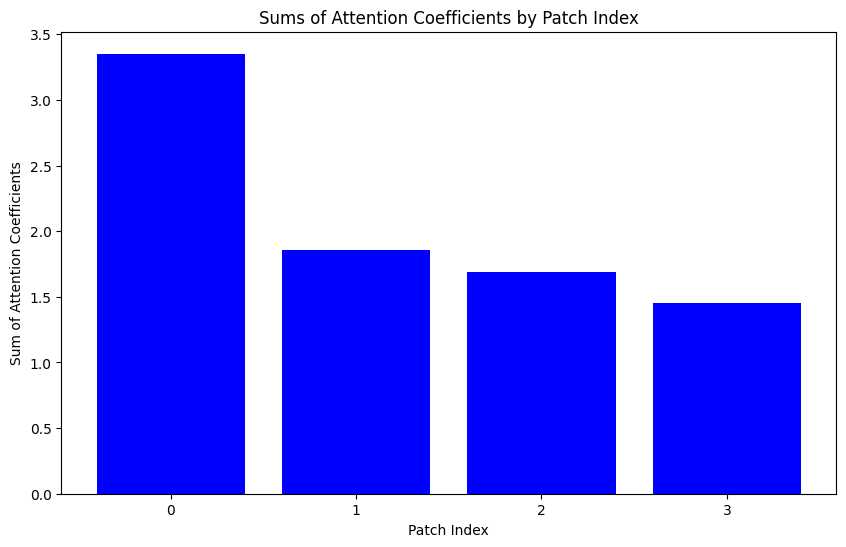

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 11%|█         | 11/100 [31:57<4:15:16, 172.10s/it]

torch.Size([418, 4, 16])
Row sums: [3.3689482 1.8580387 1.6876814 1.4558028]


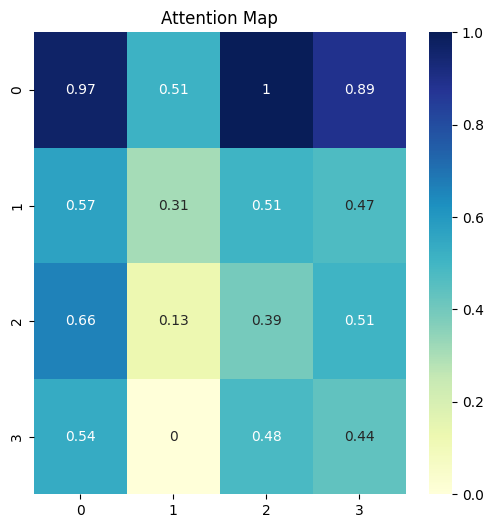

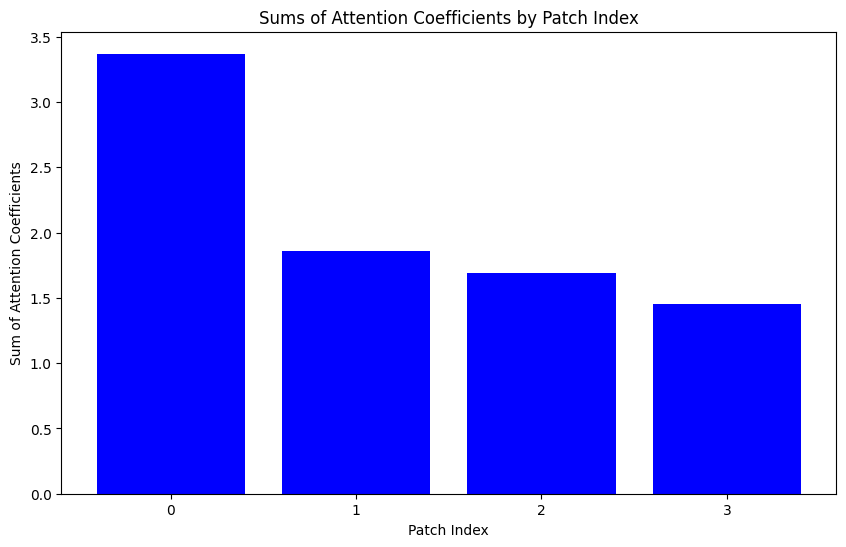

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 12%|█▏        | 12/100 [34:55<4:15:13, 174.01s/it]

torch.Size([418, 4, 16])
Row sums: [3.3876123 1.8654594 1.6893982 1.4594921]


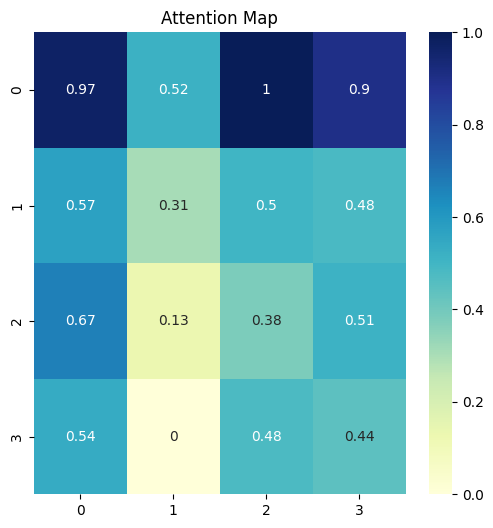

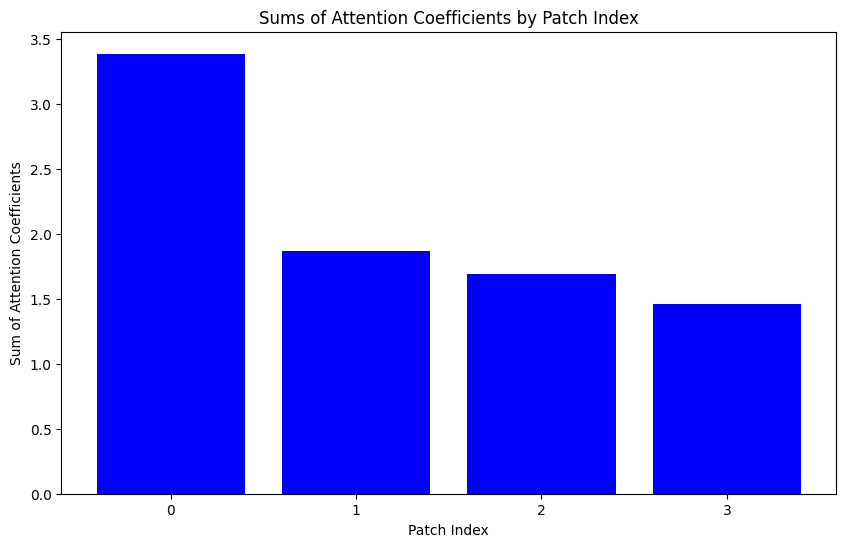

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 13%|█▎        | 13/100 [37:46<4:10:56, 173.06s/it]

torch.Size([418, 4, 16])
Row sums: [3.4071035 1.8762366 1.6935527 1.4635412]


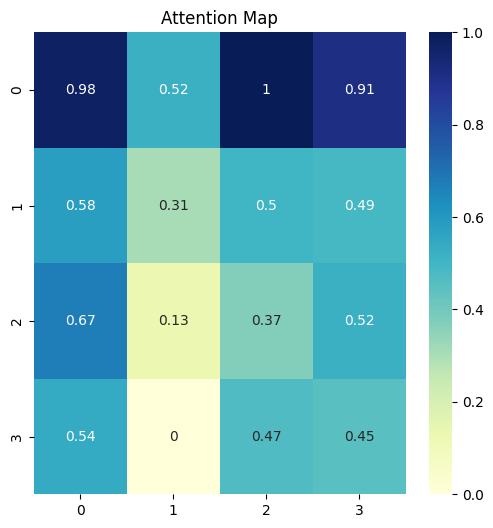

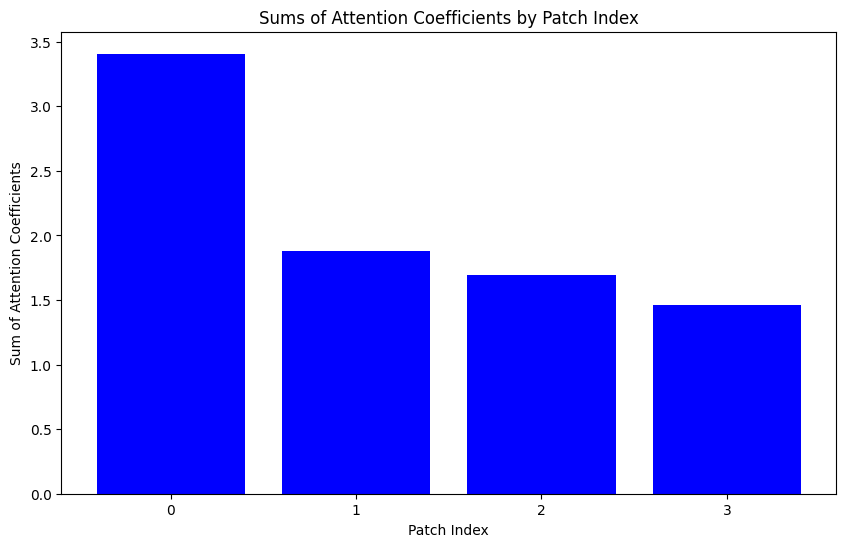

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 14%|█▍        | 14/100 [40:44<4:10:05, 174.48s/it]

torch.Size([418, 4, 16])
Row sums: [3.42701   1.890696  1.6997676 1.4683923]


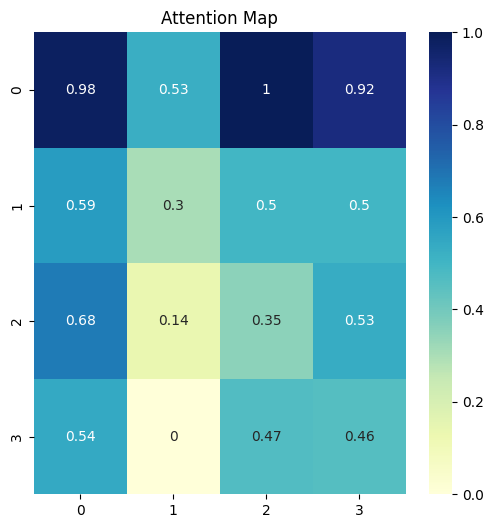

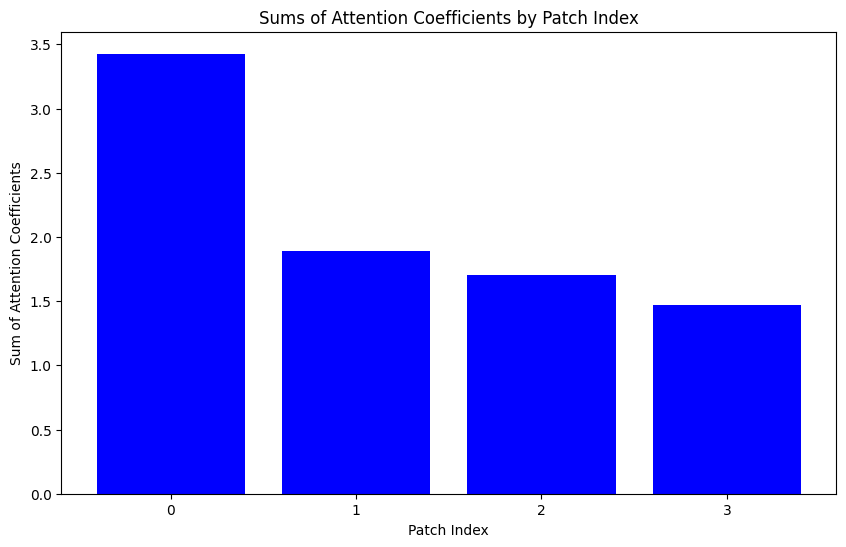

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 15%|█▌        | 15/100 [43:36<4:06:03, 173.69s/it]

torch.Size([418, 4, 16])
Row sums: [3.4469783 1.9083142 1.7075448 1.4741414]


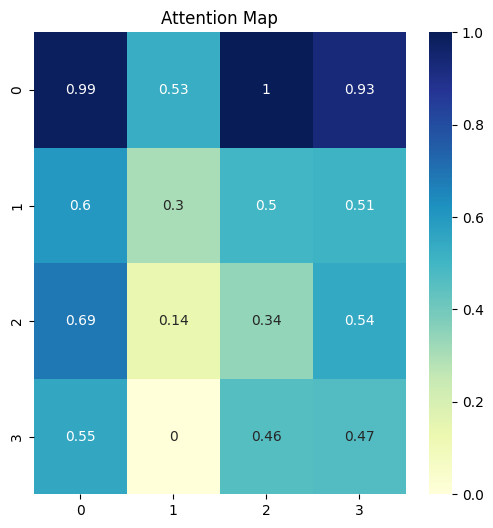

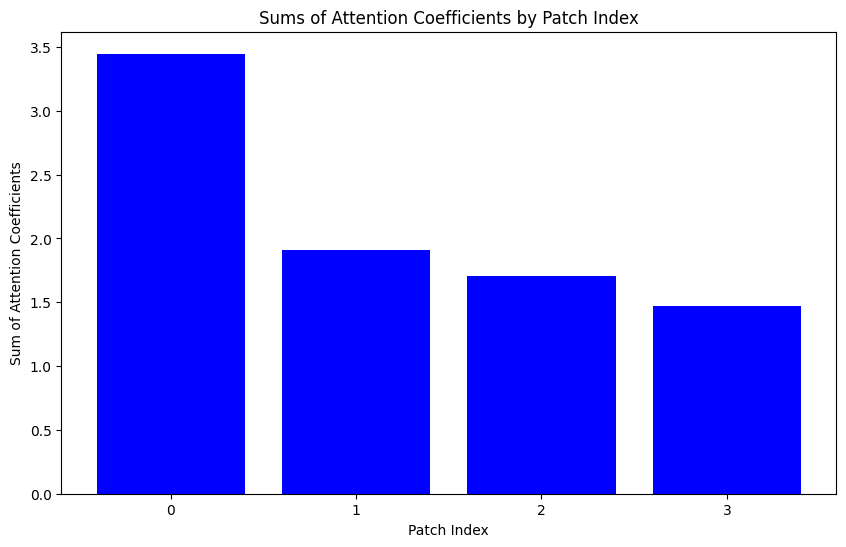

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 16%|█▌        | 16/100 [46:26<4:01:47, 172.71s/it]

torch.Size([418, 4, 16])
Row sums: [3.466904  1.9280975 1.7165043 1.480889 ]


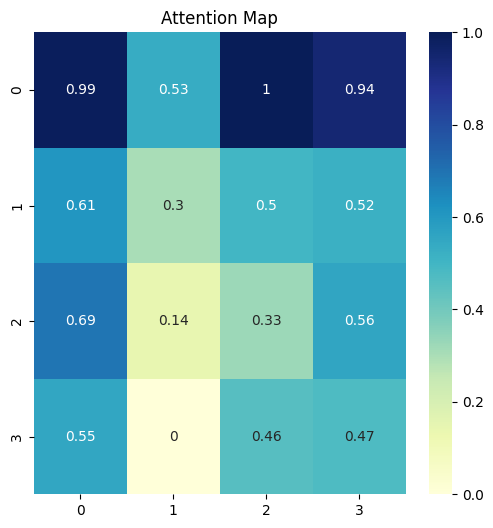

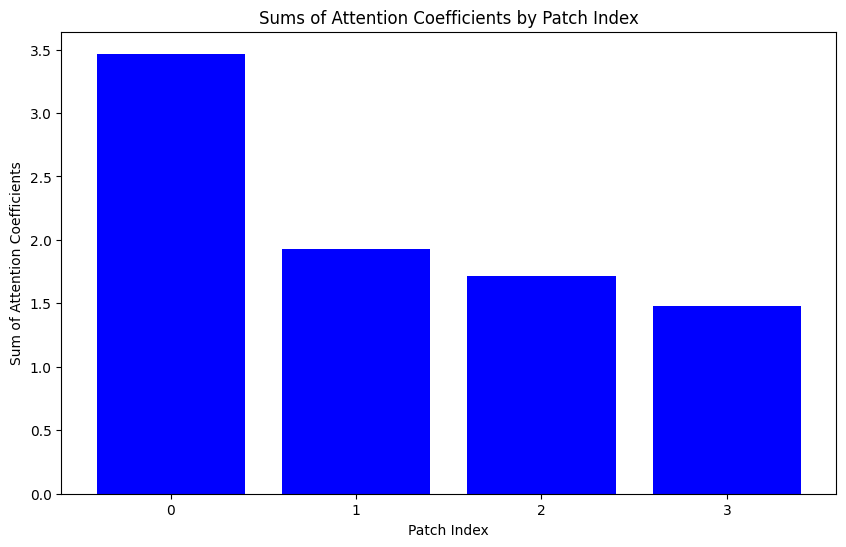

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 17%|█▋        | 17/100 [49:21<3:59:51, 173.39s/it]

torch.Size([418, 4, 16])
Row sums: [3.4866552 1.9485643 1.7263129 1.4884775]


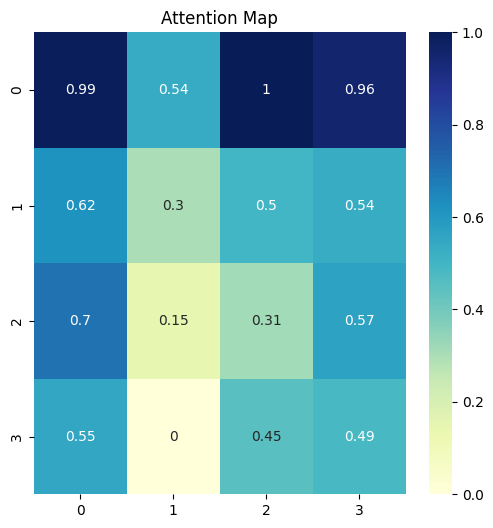

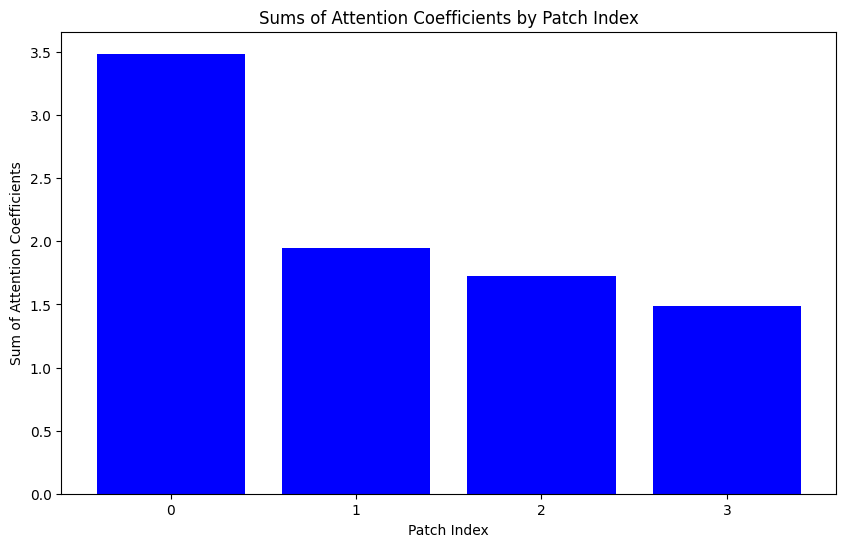

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 18%|█▊        | 18/100 [52:22<3:59:55, 175.55s/it]

torch.Size([418, 4, 16])
Row sums: [3.5059855 1.9681134 1.7365689 1.4966352]


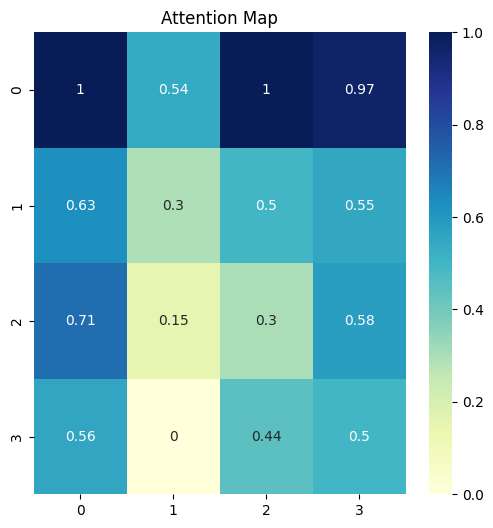

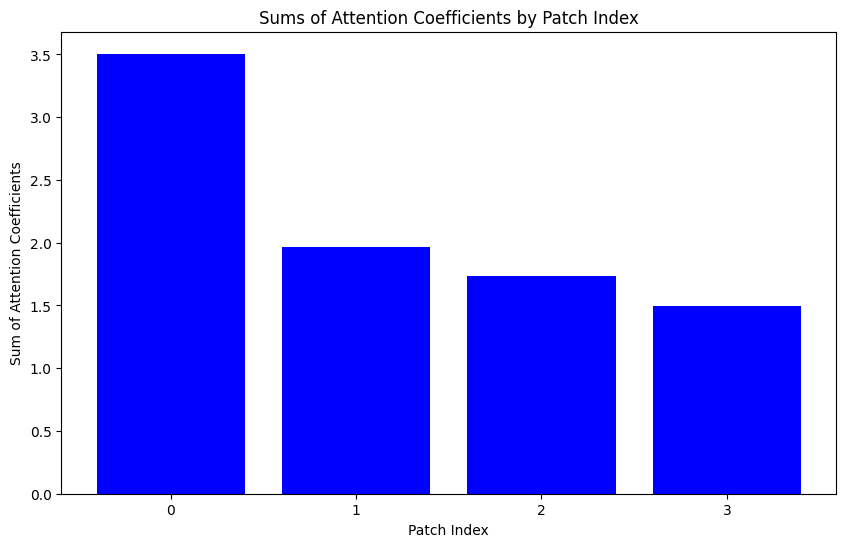

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 19%|█▉        | 19/100 [55:20<3:58:02, 176.33s/it]

torch.Size([418, 4, 16])
Row sums: [3.5242605 1.9856808 1.7467073 1.5047944]


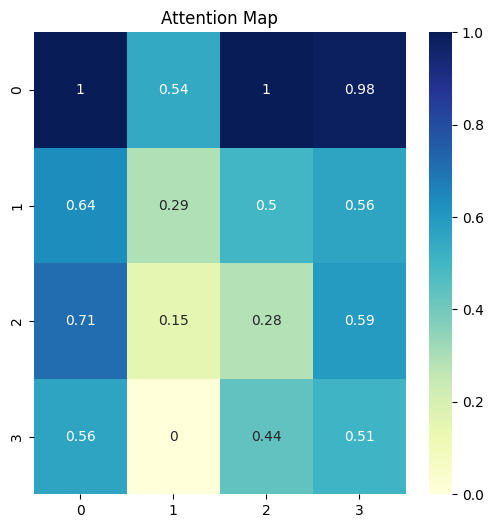

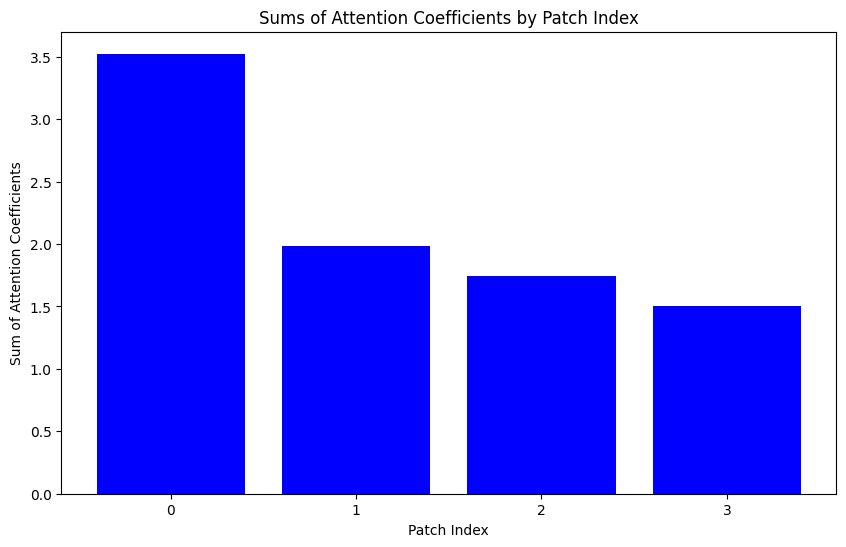

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 20%|██        | 20/100 [58:12<3:53:11, 174.90s/it]

torch.Size([418, 4, 16])
Row sums: [3.5406735 2.0011883 1.7563752 1.512423 ]


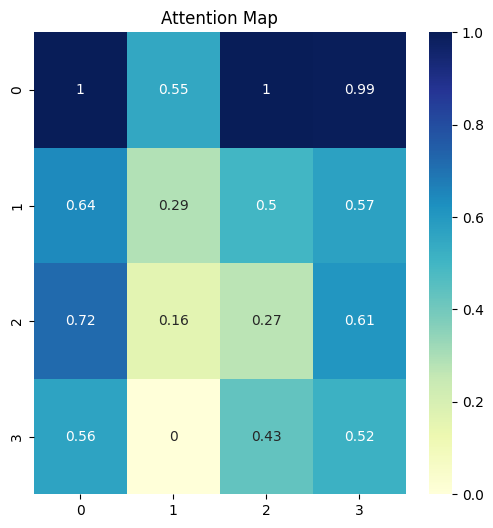

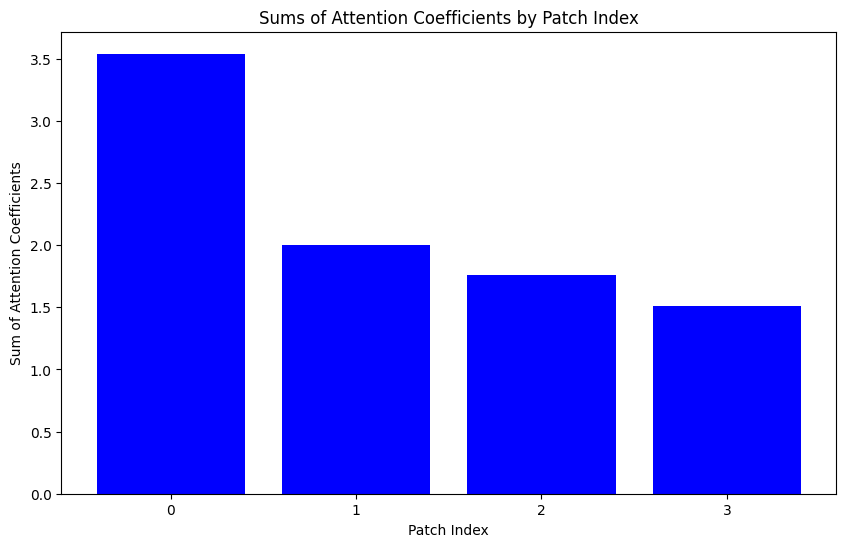

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 21%|██        | 21/100 [1:01:22<3:56:15, 179.43s/it]

torch.Size([418, 4, 16])
Row sums: [3.539033  2.00582   1.7575895 1.5125939]


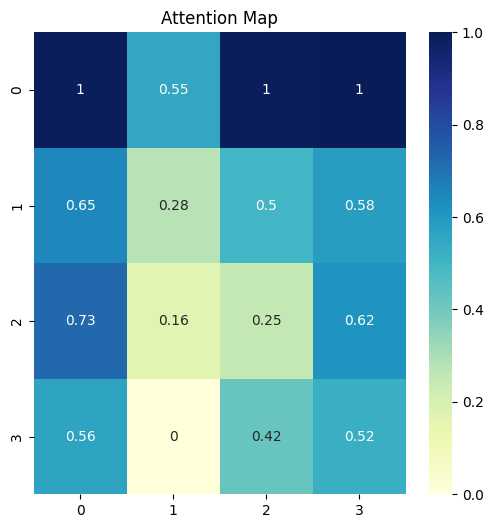

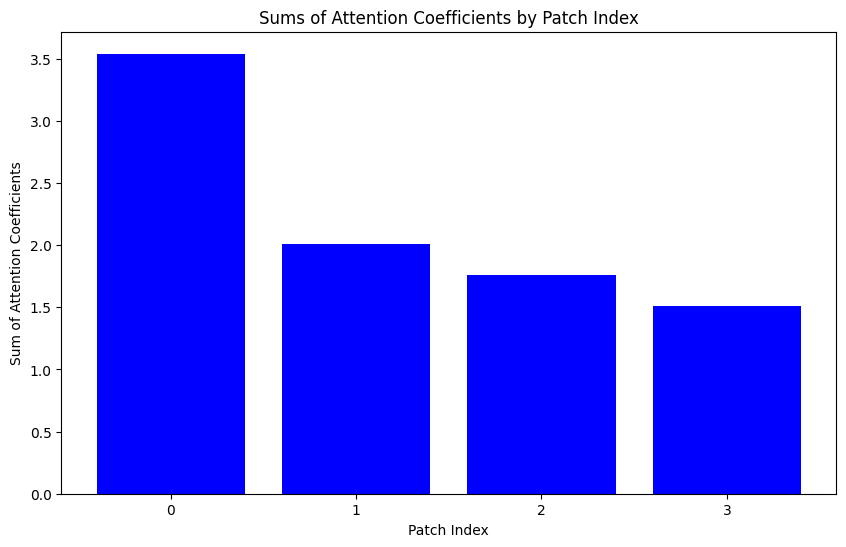

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 22%|██▏       | 22/100 [1:04:10<3:49:03, 176.20s/it]

torch.Size([418, 4, 16])
Row sums: [3.5136206 1.9965613 1.7475759 1.5026999]


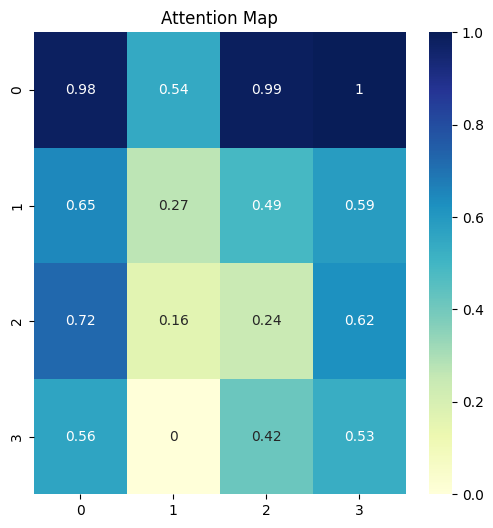

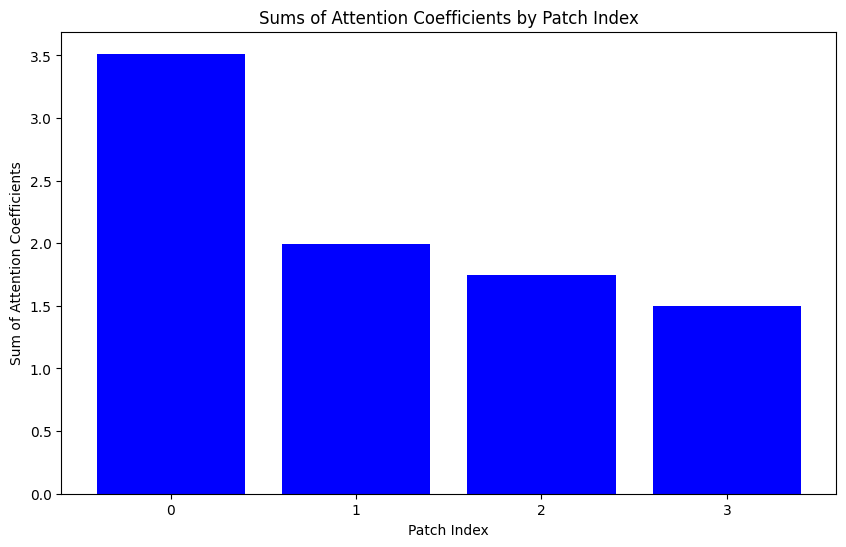

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 23%|██▎       | 23/100 [1:07:14<3:49:10, 178.58s/it]

torch.Size([418, 4, 16])
Row sums: [3.4887474 1.9872475 1.7384807 1.4931173]


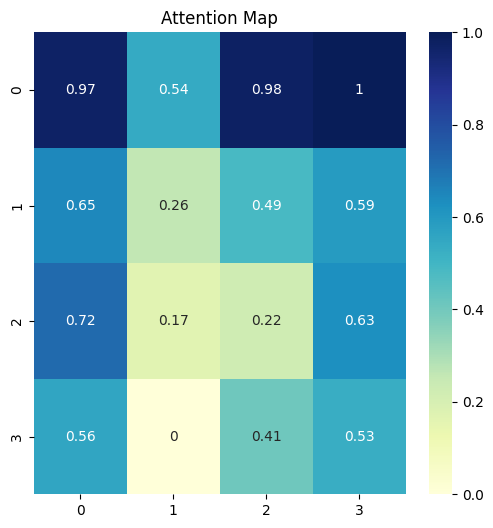

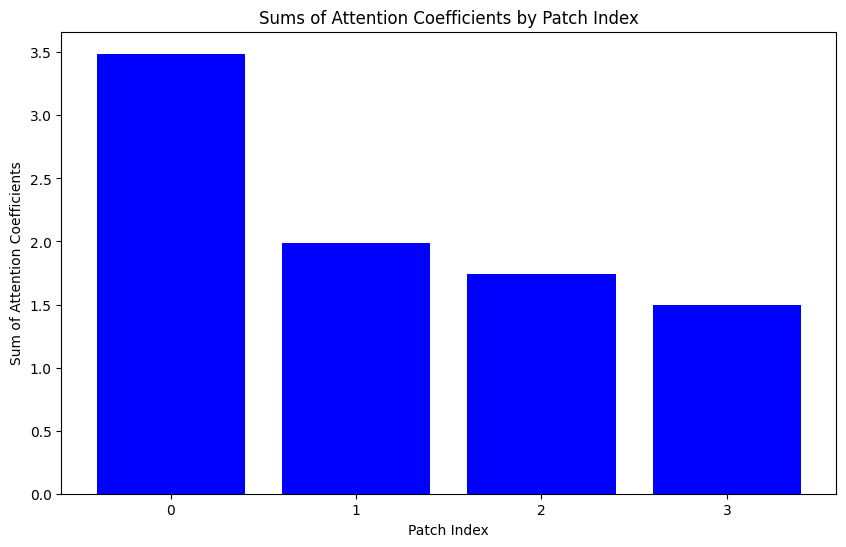

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 24%|██▍       | 24/100 [1:10:27<3:51:36, 182.85s/it]

torch.Size([418, 4, 16])
Row sums: [3.46443   1.978025  1.7306515 1.4838462]


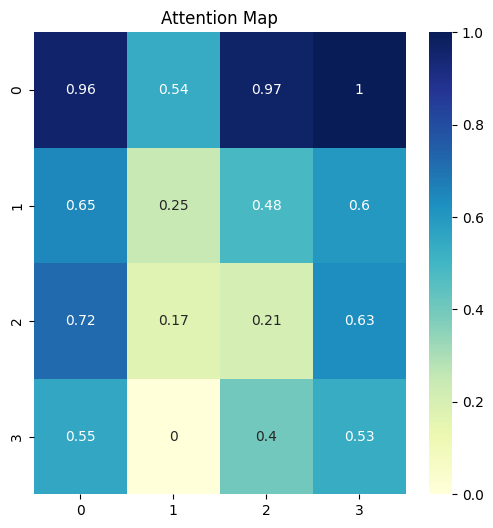

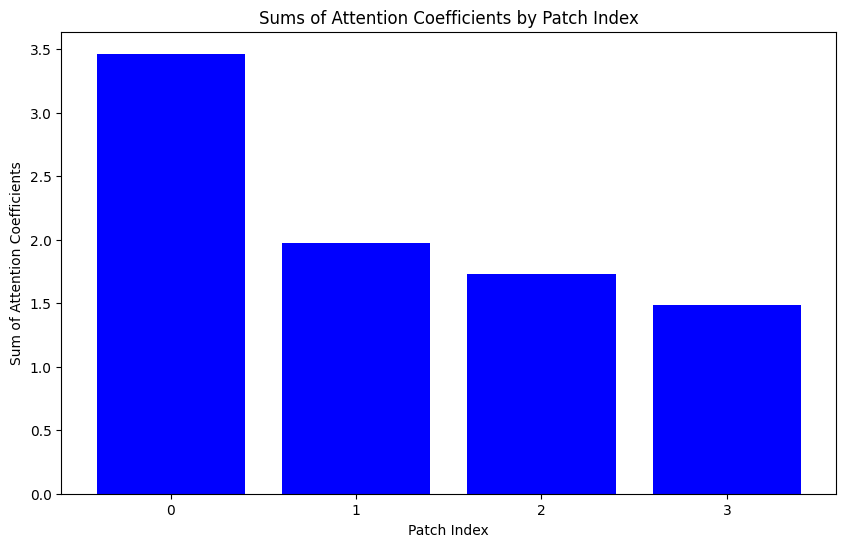

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 25%|██▌       | 25/100 [1:13:52<3:56:57, 189.57s/it]

torch.Size([418, 4, 16])
Row sums: [3.4405947 1.9688864 1.724152  1.4747068]


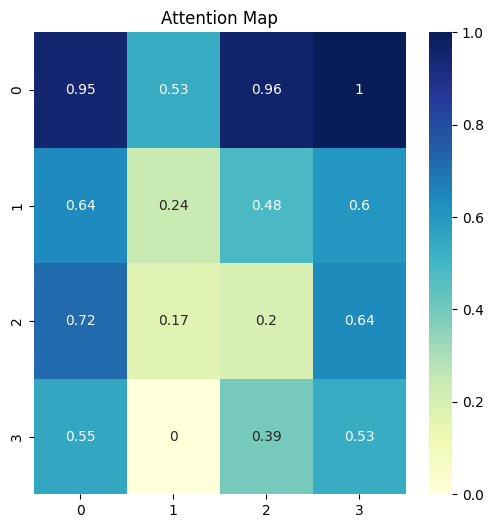

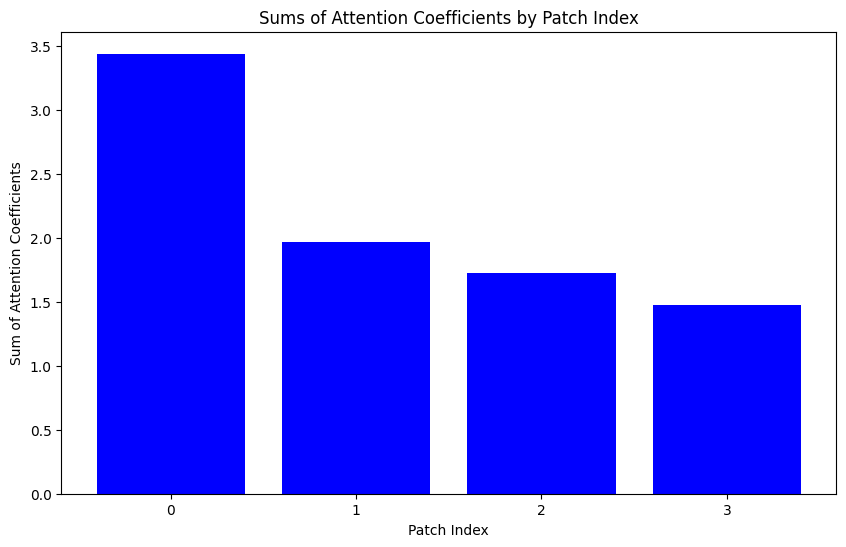

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 26%|██▌       | 26/100 [1:17:07<3:55:36, 191.03s/it]

torch.Size([418, 4, 16])
Row sums: [3.4172666 1.9598098 1.7193551 1.4655929]


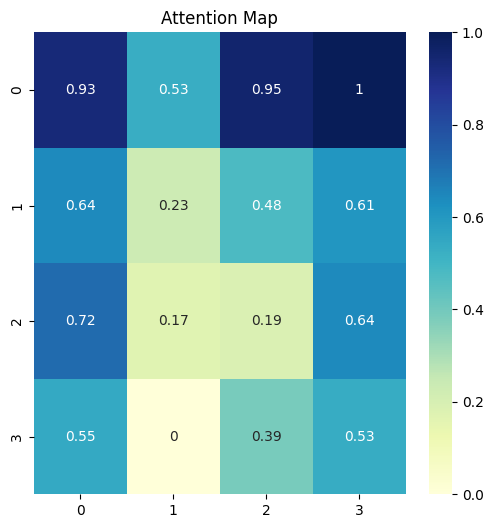

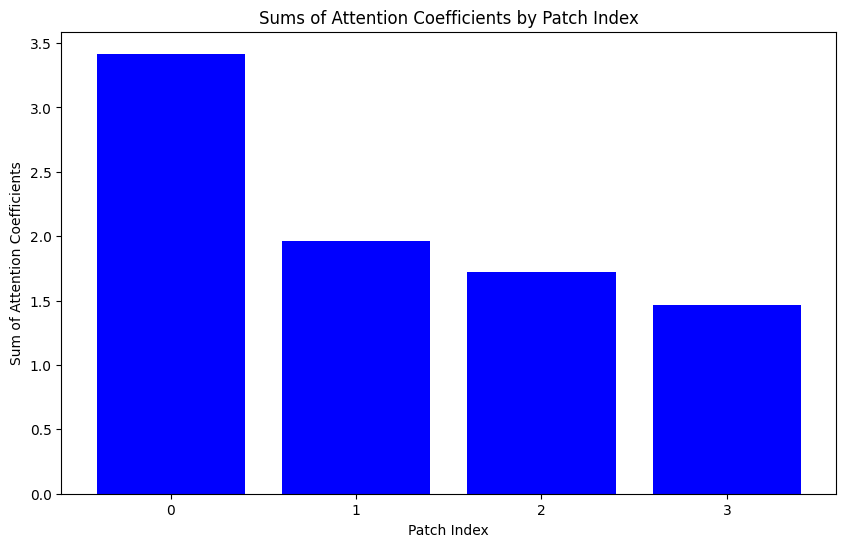

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 27%|██▋       | 27/100 [1:20:06<3:48:02, 187.44s/it]

torch.Size([418, 4, 16])
Row sums: [3.3945389 1.9509333 1.7167056 1.4564142]


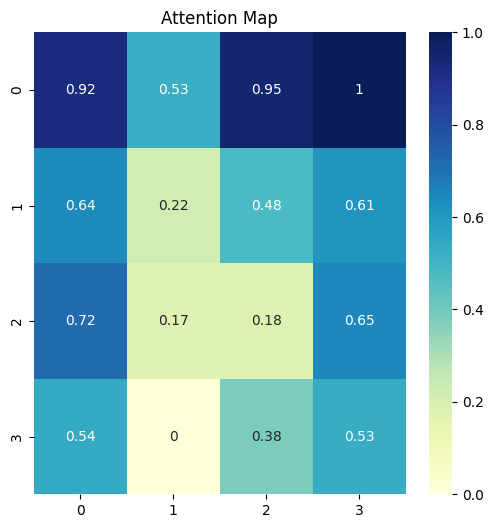

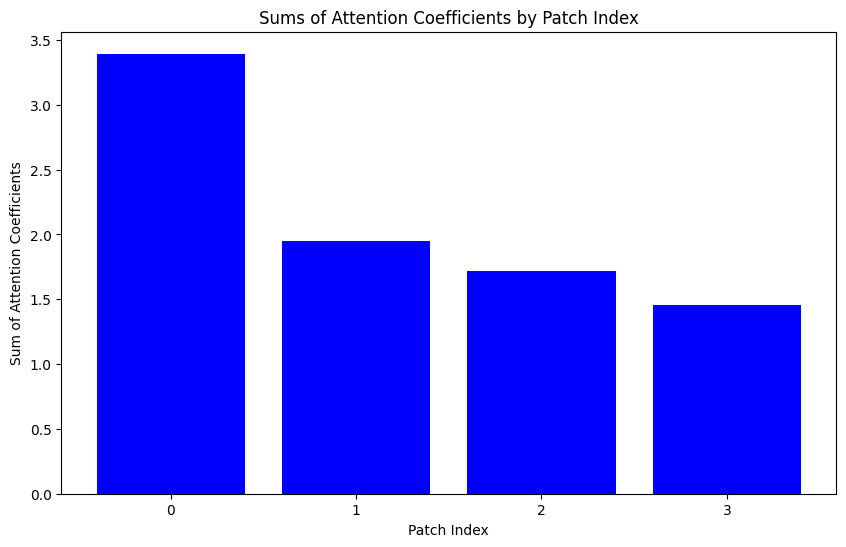

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 28%|██▊       | 28/100 [1:23:09<3:43:25, 186.18s/it]

torch.Size([418, 4, 16])
Row sums: [3.372434  1.942059  1.7164338 1.4469719]


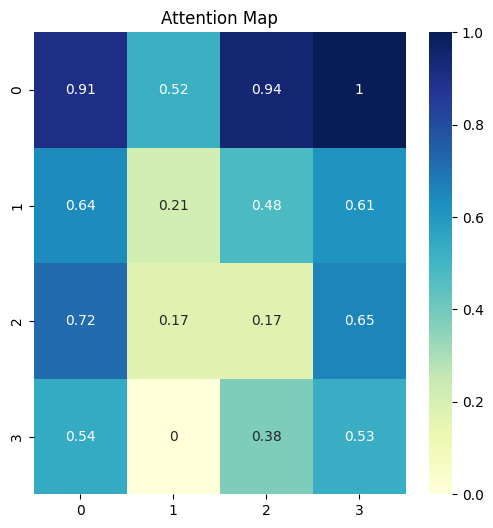

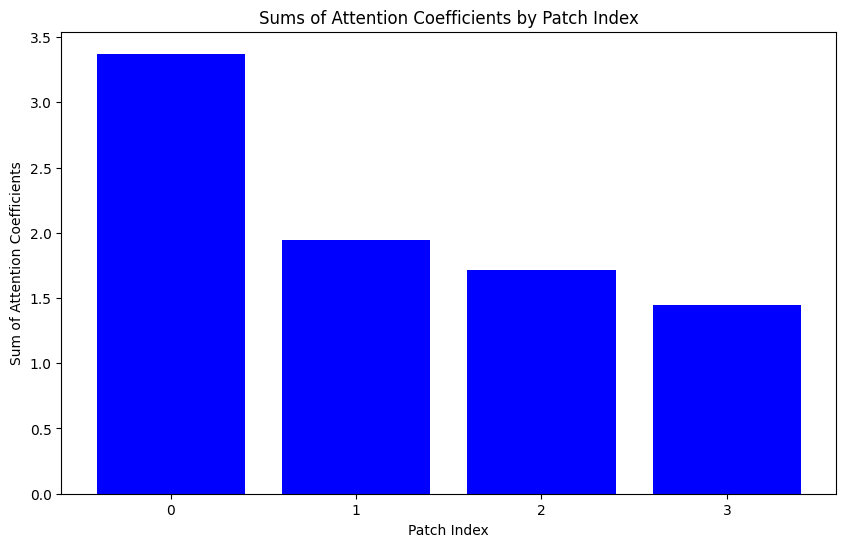

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 29%|██▉       | 29/100 [1:26:16<3:40:42, 186.51s/it]

torch.Size([418, 4, 16])
Row sums: [3.3510642 1.9333735 1.7190598 1.437363 ]


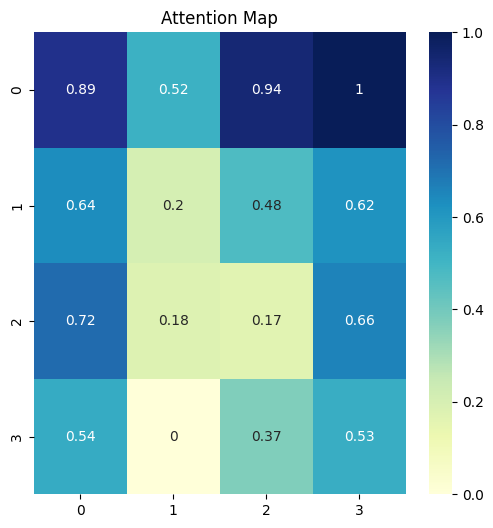

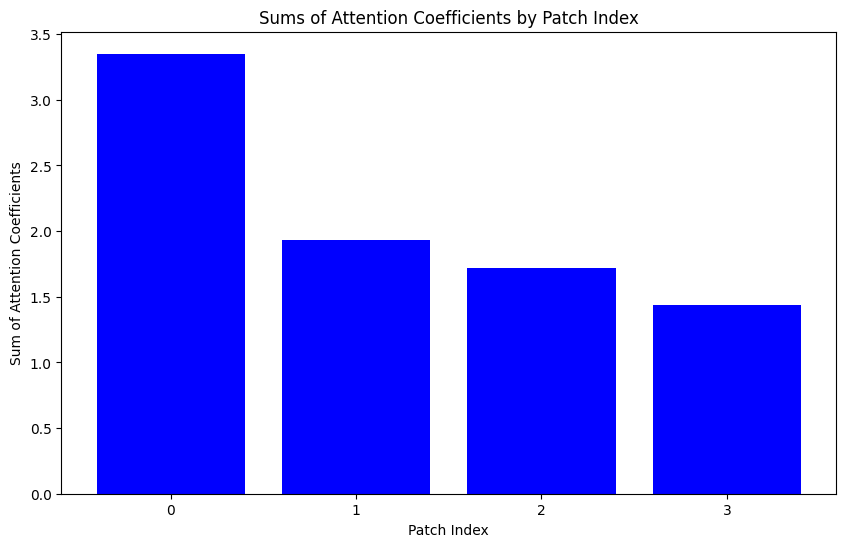

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 30%|███       | 30/100 [1:29:16<3:35:17, 184.53s/it]

torch.Size([418, 4, 16])
Row sums: [3.3304415 1.9248075 1.7246819 1.4275298]


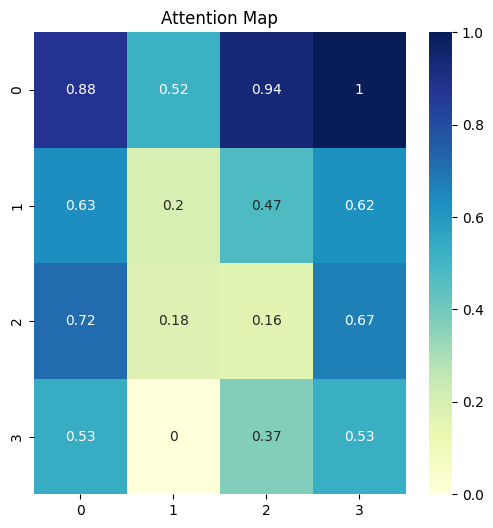

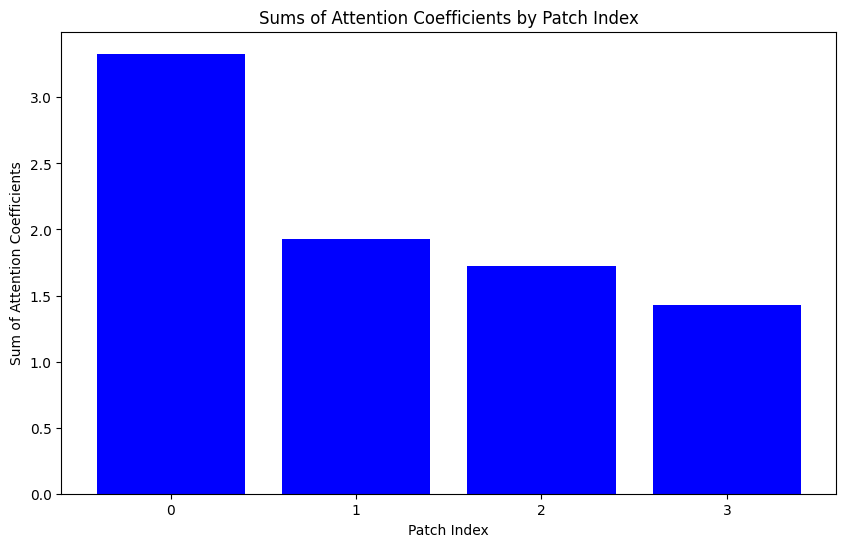

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 31%|███       | 31/100 [1:32:25<3:33:38, 185.77s/it]

torch.Size([418, 4, 16])
Row sums: [3.3105614 1.9165165 1.7334186 1.4175788]


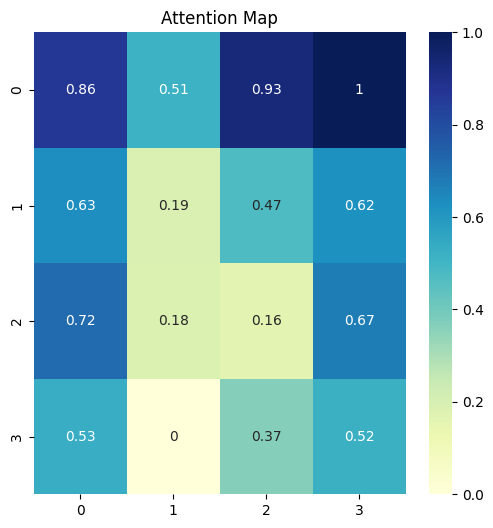

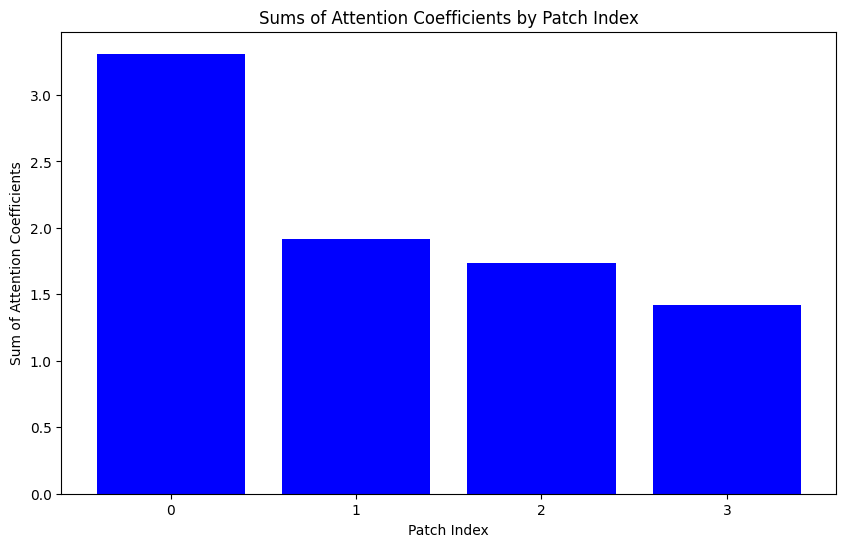

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 32%|███▏      | 32/100 [1:36:03<3:41:24, 195.36s/it]

torch.Size([418, 4, 16])
Row sums: [3.2912366 1.9086761 1.745117  1.4075543]


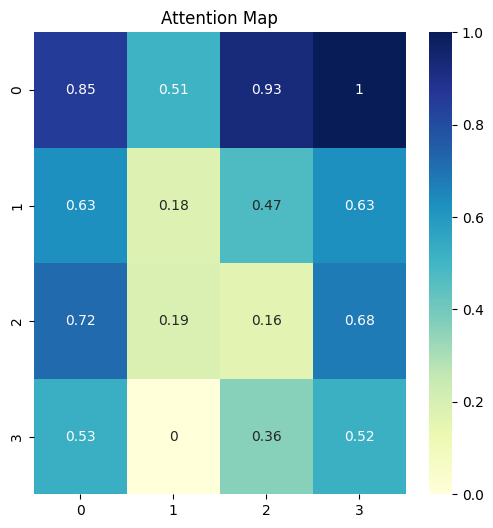

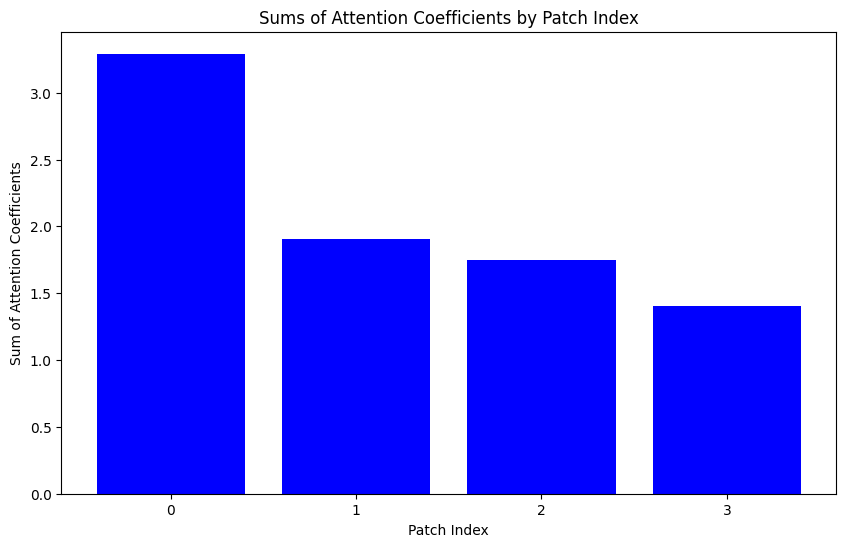

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 33%|███▎      | 33/100 [1:39:29<3:41:49, 198.65s/it]

torch.Size([418, 4, 16])
Row sums: [3.2722769 1.9013536 1.7596021 1.3975201]


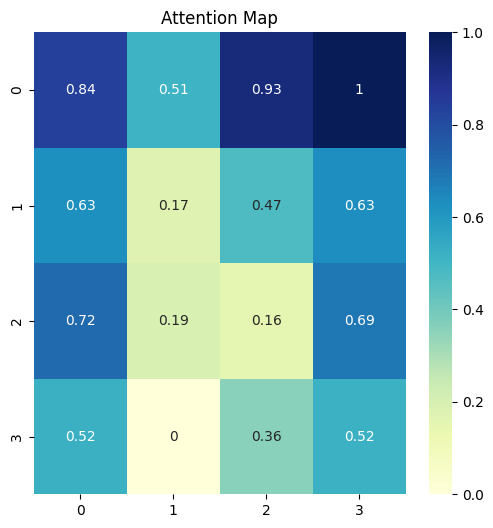

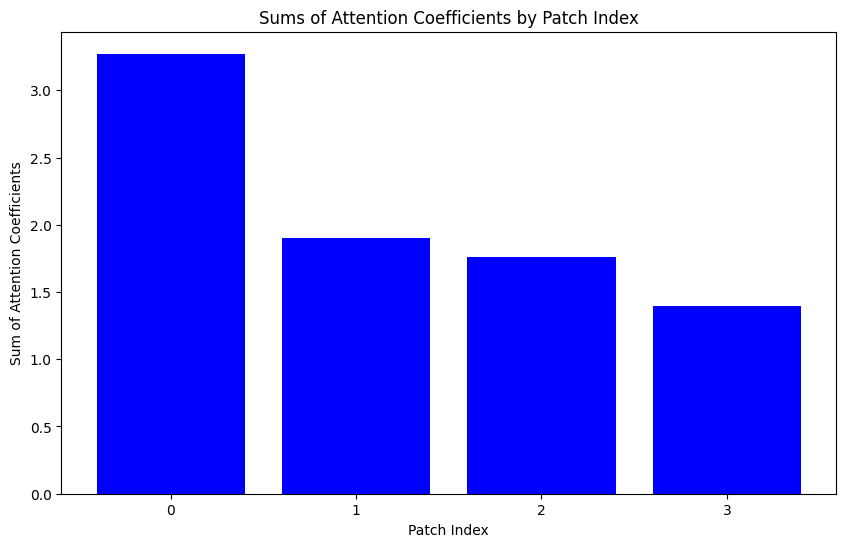

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 34%|███▍      | 34/100 [1:42:37<3:35:04, 195.52s/it]

torch.Size([418, 4, 16])
Row sums: [3.2533484 1.8949003 1.7766637 1.387521 ]


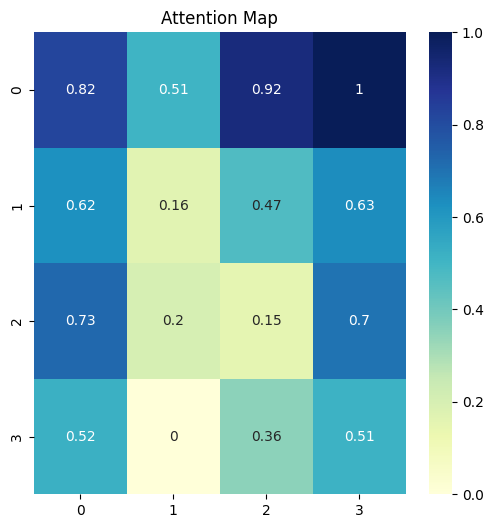

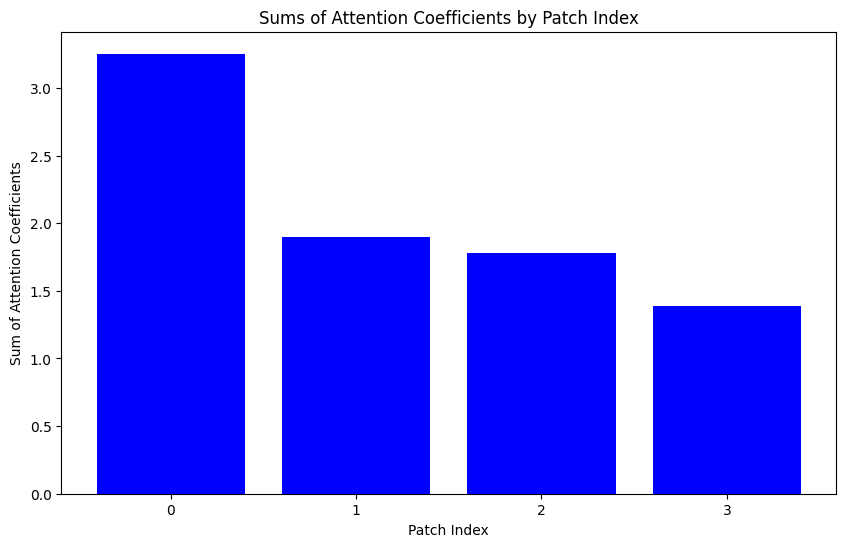

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 35%|███▌      | 35/100 [1:45:27<3:23:33, 187.91s/it]

torch.Size([418, 4, 16])
Row sums: [3.234055  1.8894154 1.7960649 1.3775151]


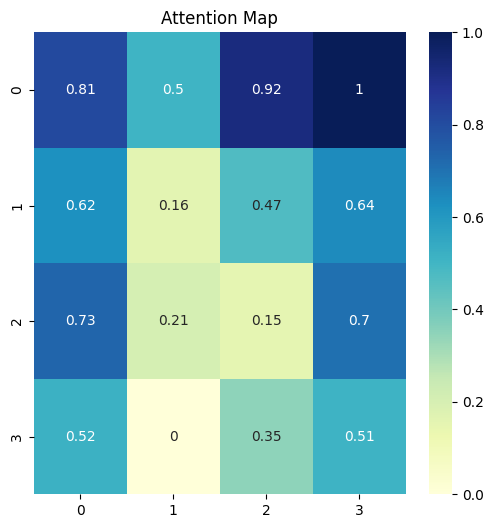

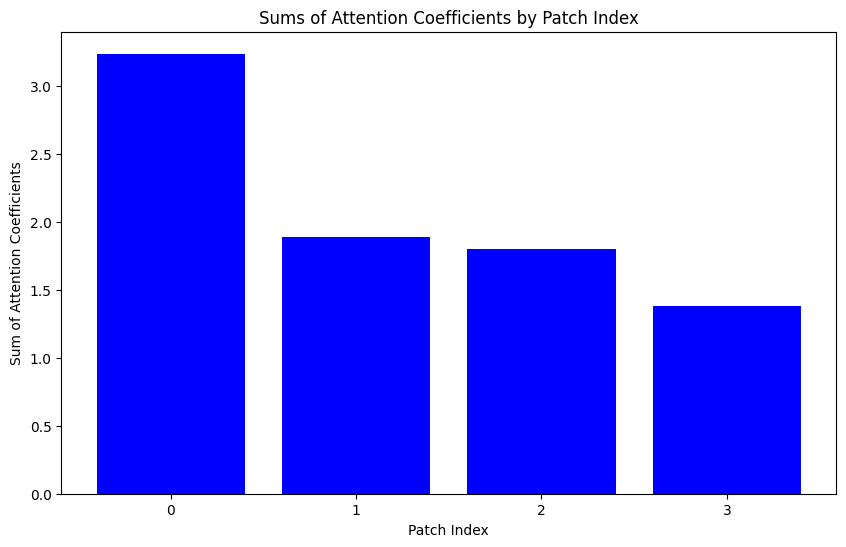

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 36%|███▌      | 36/100 [1:48:21<3:15:57, 183.71s/it]

torch.Size([418, 4, 16])
Row sums: [3.2140555 1.8850398 1.8176132 1.3674647]


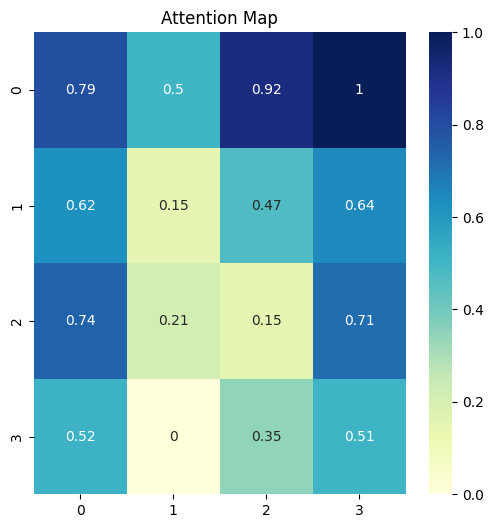

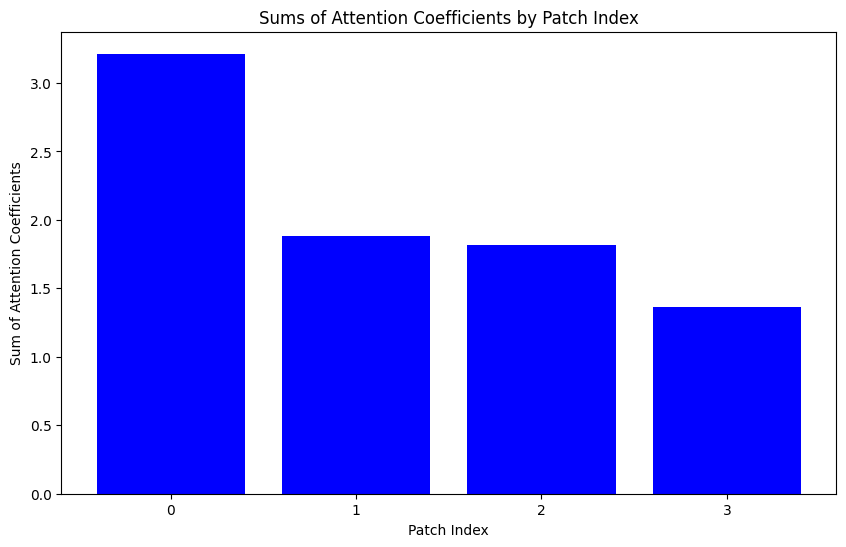

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 37%|███▋      | 37/100 [1:51:27<3:13:29, 184.28s/it]

torch.Size([418, 4, 16])
Row sums: [3.1930497 1.881892  1.8410466 1.3572888]


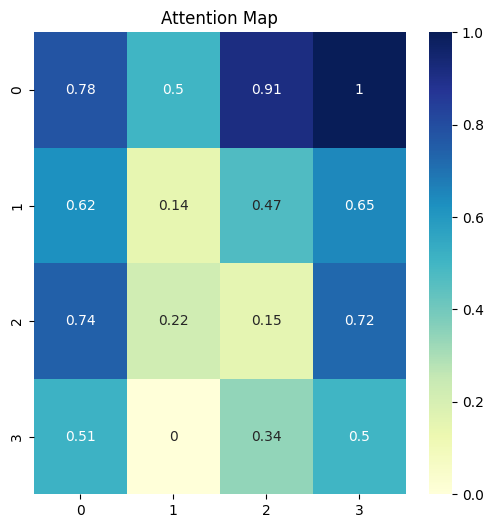

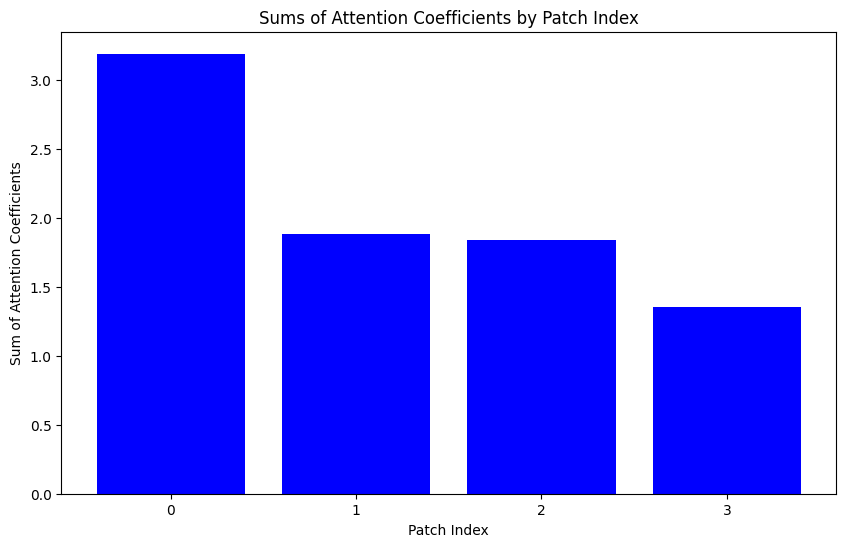

tensor([0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2,
        1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1,
        0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0,
        1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
        1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1,

 38%|███▊      | 38/100 [1:55:39<3:31:31, 204.71s/it]

torch.Size([418, 4, 16])


 38%|███▊      | 38/100 [1:55:50<3:08:59, 182.90s/it]


KeyboardInterrupt: 

In [26]:
for iepoch in tqdm(range(100)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

torch.Size([121, 4, 16])
Row sums: [2.8059328 1.3324192 1.5700494 1.050494 ]


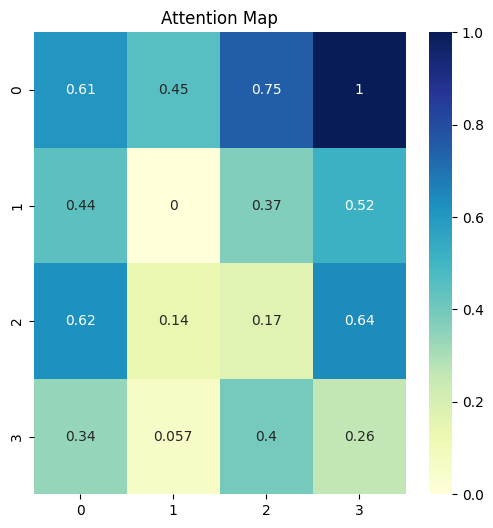

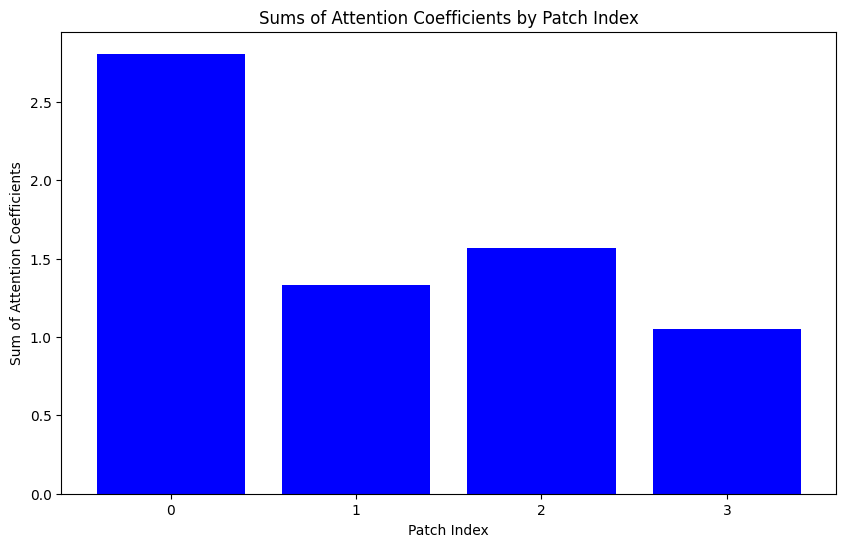

tensor([2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0,
        1, 0, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0,
        1, 2, 1, 1, 0, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 0,
        2, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0,
        0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 1, 0, 2, 0,
        1])
tensor([2., 1., 1., 0., 2., 2., 1., 2., 1., 1., 0., 1., 0., 0., 0., 1., 0., 2.,
        0., 2., 2., 0., 0., 0., 1., 0., 1., 2., 2., 1., 2., 2., 0., 2., 2., 2.,
        2., 2., 0., 0., 0., 0., 2., 0., 1., 2., 2., 0., 1., 2., 1., 1., 0., 2.,
        0., 2., 1., 1., 2., 1., 2., 0., 2., 2., 0., 1., 0., 1., 0., 1., 0., 0.,
        2., 0., 0., 0., 1., 1., 1., 1., 2., 0., 1., 1., 2., 0., 1., 2., 0., 0.,
        2., 2., 2., 1., 2., 0., 0., 0., 0., 0., 1., 1., 0., 2., 1., 1., 1., 1.,
        2., 0., 1., 2., 2., 0., 2., 2., 1., 0., 2., 0., 1.],
       dtype=torch.float64)

Accuracy: 0.991735

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)

loss = criterion(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')

In [32]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/load_digits/qsann_classifier_multi_3.pth"

In [33]:
# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")


Model parameters saved.


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([418, 4, 16])
Row sums: [2.96508   1.0741432 2.6555884 2.0715456]


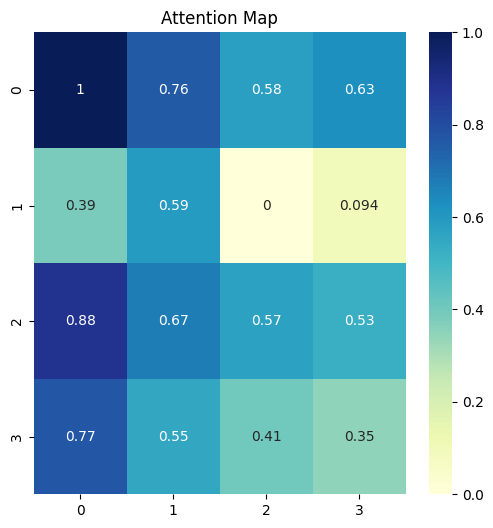

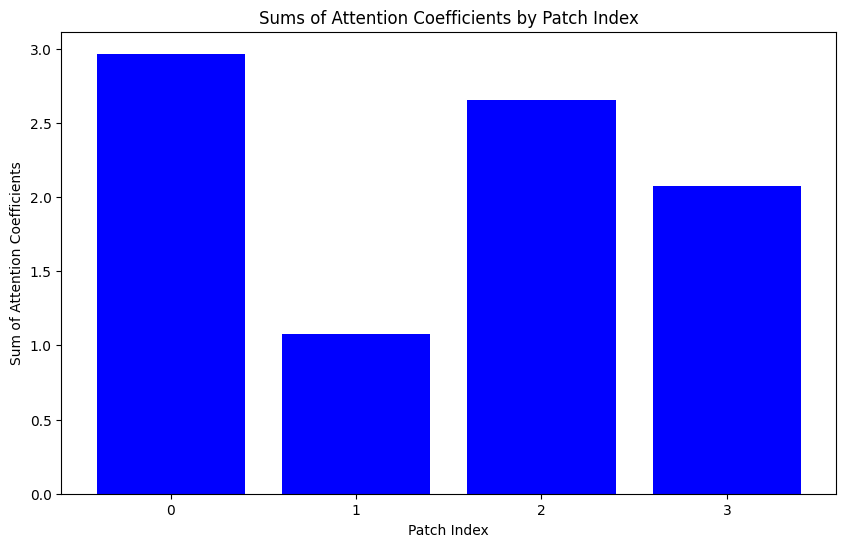

  0%|          | 0/30 [01:56<?, ?it/s]


IndexError: Target 7 is out of bounds.

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score
from tqdm import tqdm

for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    
    # Convert X_train to a PyTorch tensor and make predictions
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    predictions = model(X_tensor)  # Ensure predictions have shape (batch_size, num_classes)
    label = torch.tensor(y_train, dtype=torch.long)

    # Calculate loss
    loss = criterion(predictions, label)

    # Convert predictions and labels to numpy for sklearn metrics
    preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
    labels_np = label.numpy()  # Convert labels to numpy

    # For multi-class classification, get predicted classes by selecting the class with the highest score
    predicted_classes = np.argmax(preds_np, axis=1)

    # Calculate Accuracy
    acc = accuracy_score(labels_np, predicted_classes)

    # Print accuracy and loss
    print(f'\nAccuracy: {acc}\n')
    print(f'Loss: {loss}\n')

    # Backpropagation
    loss.backward()
    optimizer.step()

# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([418, 4, 16])
Row sums: [2.96508   1.0741432 2.6555884 2.0715456]


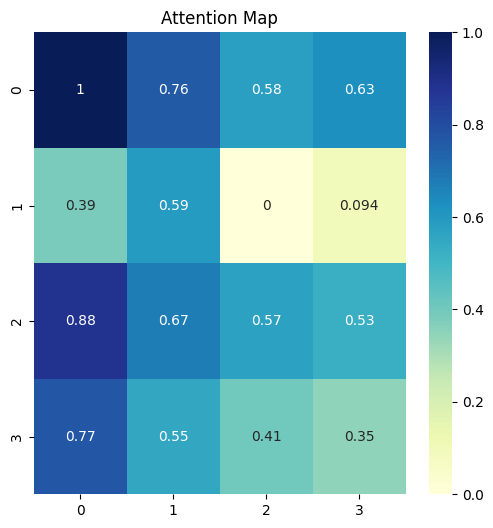

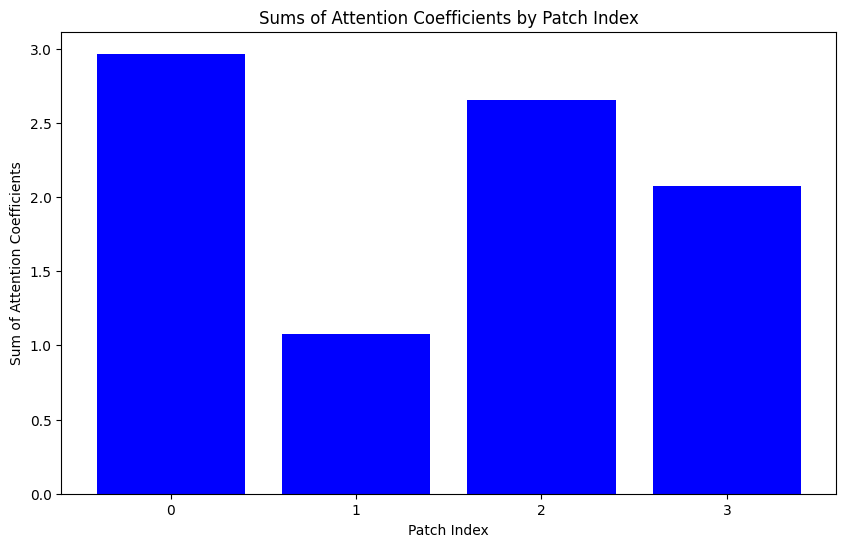

  0%|          | 0/30 [01:54<?, ?it/s]


AxisError: axis 1 is out of bounds for array of dimension 1

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    
    # Convert predictions and labels to numpy for sklearn metrics
    preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
    labels_np = label.numpy()  # Convert labels to numpy

    # Get predicted classes
    predicted_classes = np.argmax(preds_np, axis=1)

    # Calculate Accuracy
    acc = accuracy_score(labels_np, predicted_classes)

    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    
# Save the model parameters
torch.save(model.state_dict(), model_save_path)
print("Model parameters saved.")

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = model(X_tensor.float())  # Shape (batch_size, num_classes)
label = torch.tensor(y_test)

# Calculate loss and accuracy
loss = criterion(predictions, label)

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = accuracy_score(labels_np, predicted_classes)

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')


In [ ]:
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
    
#     # Convert X_train to a PyTorch tensor and make predictions
#     X_tensor = torch.tensor(X_train, dtype=torch.float32)
#     predictions = model(X_tensor).squeeze(1)
#     label = torch.tensor(y_train, dtype=torch.long)

#     # Calculate loss
#     loss = criterion(predictions, label.float())

#     # Calculate accuracy using sklearn's accuracy_score
#     # Get predicted classes by taking argmax along the class dimension
#     predicted_classes = predictions.argmax(dim=1).detach().numpy()
#     true_classes = label.numpy()
    
#     # Calculate accuracy
#     acc = accuracy_score(true_classes, predicted_classes)
    
#     # Print accuracy and loss
#     print(f'\nAccuracy: {acc}\n')
#     print(f'Loss: {loss}\n')

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
    
# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")


In [32]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [33]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(4, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

/tmp/ipykernel_146522/3871152753.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_model.load_state_dict(torch.load(model_save_path))


FileNotFoundError: [Errno 2] No such file or directory: '/home/jaeyeob/QVT/result/load_digits/qsann_classifier_multi.pth'

Row sums: [1.0047963 3.183377  1.4706175 3.6448889]


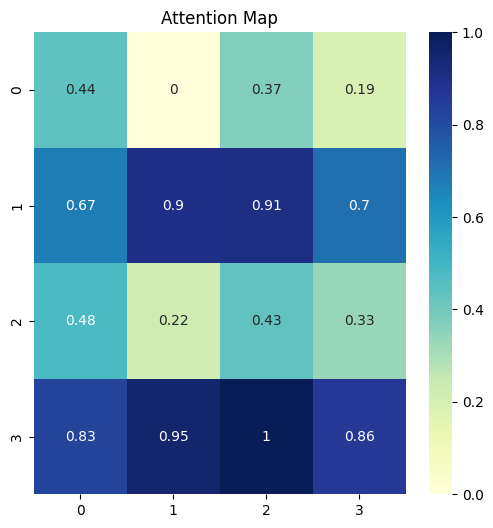

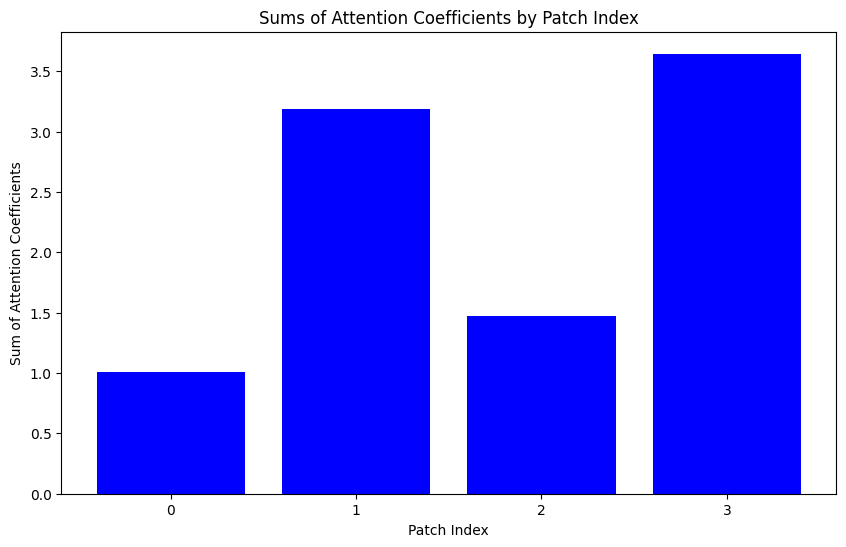


Accuracy: 0.9871794581413269

Loss: 164.62571716308594

AUROC: 0.9993408042188531

Precision: 1.0

Recall: 0.975609756097561

F1 Score: 0.9876543209876543

AUPRC: 0.9994192799070849



/tmp/ipykernel_290477/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [26]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


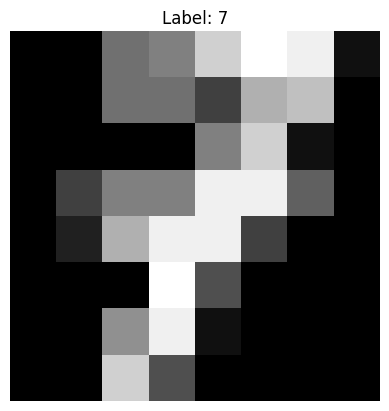

In [18]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# load_digits 데이터셋 로드
digits = load_digits()

# 첫 번째 샘플 추출
image = digits.images[7]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {digits.target[7]}')
plt.axis('off')
plt.show()


In [20]:
image = digits.images[7]

array([[ 0.,  0.,  7.,  8., 13., 16., 15.,  1.],
       [ 0.,  0.,  7.,  7.,  4., 11., 12.,  0.],
       [ 0.,  0.,  0.,  0.,  8., 13.,  1.,  0.],
       [ 0.,  4.,  8.,  8., 15., 15.,  6.,  0.],
       [ 0.,  2., 11., 15., 15.,  4.,  0.,  0.],
       [ 0.,  0.,  0., 16.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  9., 15.,  1.,  0.,  0.,  0.],
       [ 0.,  0., 13.,  5.,  0.,  0.,  0.,  0.]])

In [22]:
single = np.array([split_into_non_overlapping_patches(image)])
single = single.reshape(single.shape[0], single.shape[1], -1)

In [23]:
single

array([[[ 0.,  0.,  7.,  8.,  0.,  0.,  7.,  7.,  0.,  0.,  0.,  0.,
          0.,  4.,  8.,  8.],
        [13., 16., 15.,  1.,  4., 11., 12.,  0.,  8., 13.,  1.,  0.,
         15., 15.,  6.,  0.],
        [ 0.,  2., 11., 15.,  0.,  0.,  0., 16.,  0.,  0.,  9., 15.,
          0.,  0., 13.,  5.],
        [15.,  4.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]]])

In [24]:
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample


In [25]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [26]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(4, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
)

Row sums: [2.6687312 2.7574587 2.070386  3.0981789]


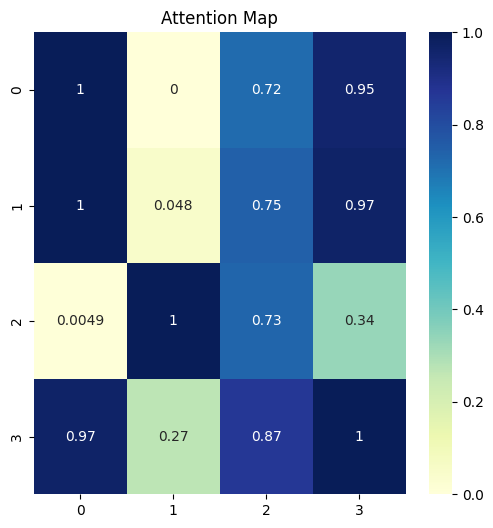

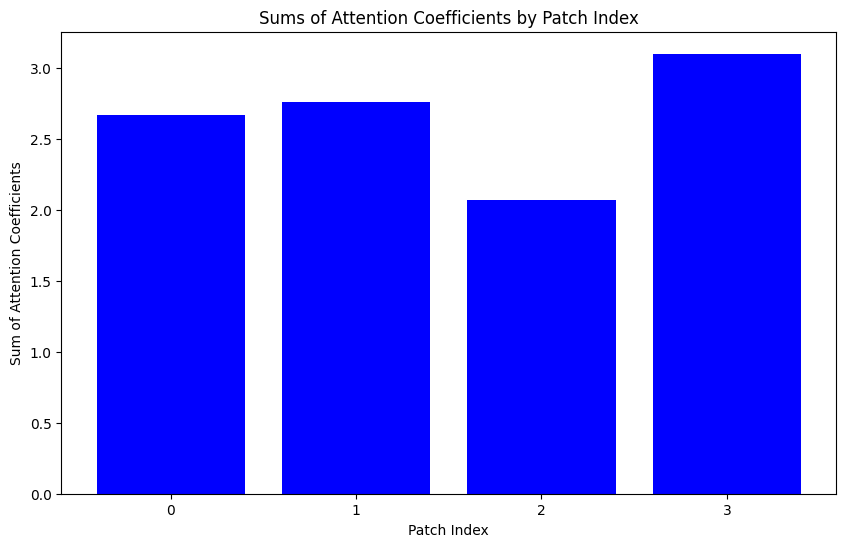

Predicted class for the sample: 1.0
Row sums: [2.6687312 2.7574587 2.070386  3.0981789]


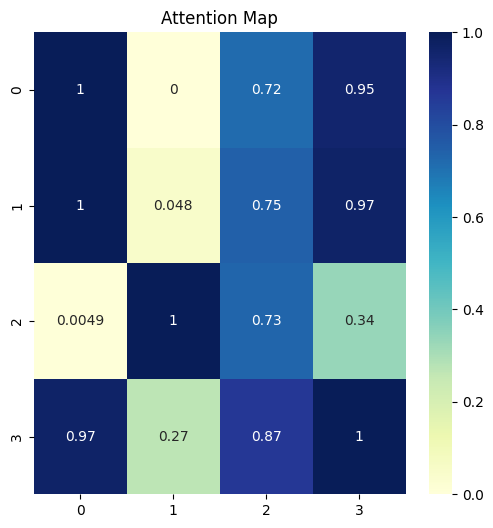

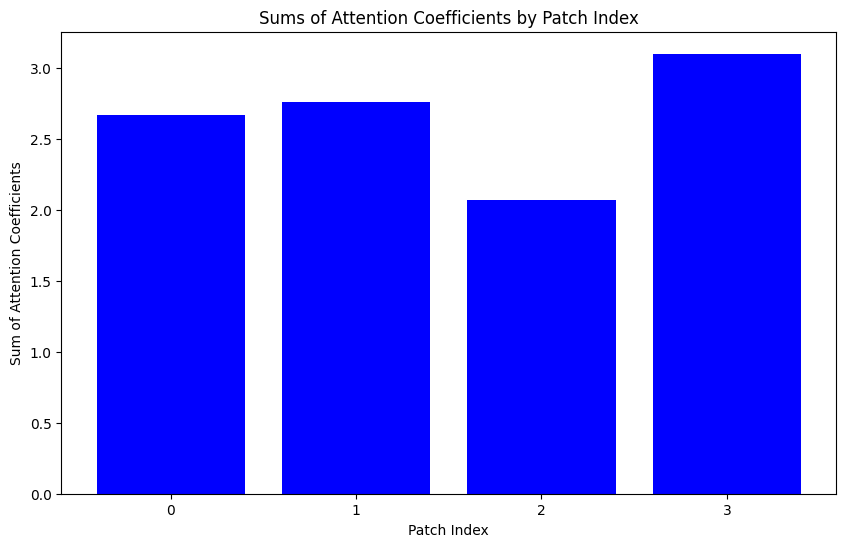

Extracted attention values: tensor([[[1.0000, 0.7250, 0.9217, 0.9872],
         [0.9997, 0.7381, 0.9300, 0.9905],
         [0.7264, 1.0000, 0.9259, 0.8171],
         [0.9911, 0.7981, 0.9633, 0.9995]]])


In [27]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    # predictions = model(X_tensor.float()).squeeze(1)
    # predicted_class = (torch.round(torch.sigmoid(prediction))).item()
        # Convert the prediction to a class (0 or 1)
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")
    # print(f"Predicted class for the sample: {prediction}")
    # print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

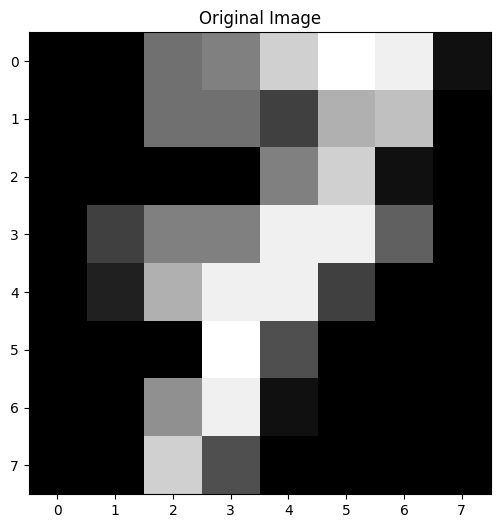

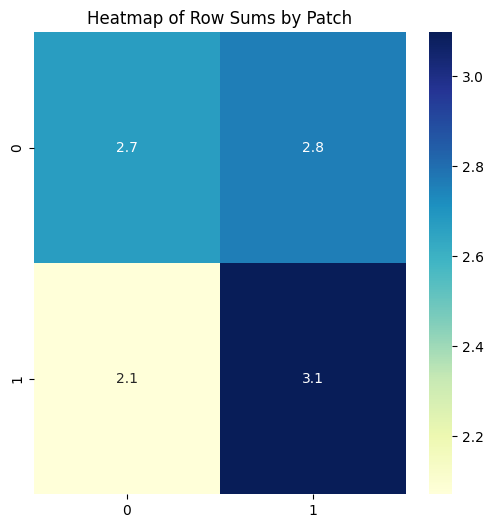

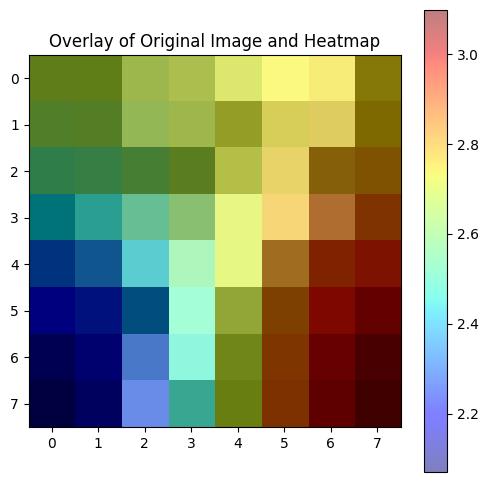

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(2, 2)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()
# from sklearn.datasets import load_digits
# import matplotlib.pyplot as plt

# # load_digits 데이터셋 로드
# digits = load_digits()

# # 첫 번째 샘플 추출
# image = digits.images[7]

# # 이미지 시각화
# plt.imshow(image, cmap='gray')
# plt.title(f'Label: {digits.target[7]}')
# plt.axis('off')
# plt.show()


    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = digits.images[7]

# Example row sums based on output
row_sums =[2.6687312, 2.7574587, 2.070386, 3.0981789]


# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(2, 2))


-----------------------------------------

In [26]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [1, 7])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [1, 7])
X_test, y_test = X_test[test_mask], y_test[test_mask]

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [27]:
X_test[0]

array([[ 0.,  0.,  2., 12., 12., 12.,  9.,  2.],
       [ 0.,  0.,  9., 15., 12., 13., 16.,  5.],
       [ 0.,  0., 12.,  8.,  0.,  8., 10.,  0.],
       [ 0.,  1., 16.,  3.,  3., 15.,  2.,  0.],
       [ 0.,  1.,  3.,  0., 12.,  7.,  0.,  0.],
       [ 0.,  0.,  0.,  4., 13.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 13.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  3., 15.,  3.,  0.,  0.,  0.]])

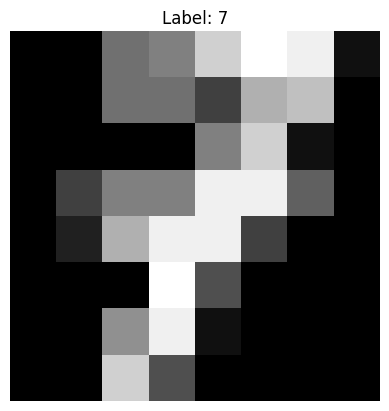

In [31]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# load_digits 데이터셋 로드
digits = load_digits()

# 첫 번째 샘플 추출
image = digits.images[7]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {digits.target[7]}')
plt.axis('off')
plt.show()


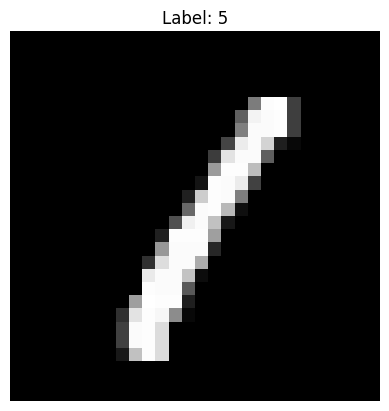

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

# MNIST 데이터셋 로드
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 첫 번째 샘플 추출
image = train_images[3]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {train_labels[0]}')
plt.axis('off')
plt.show()


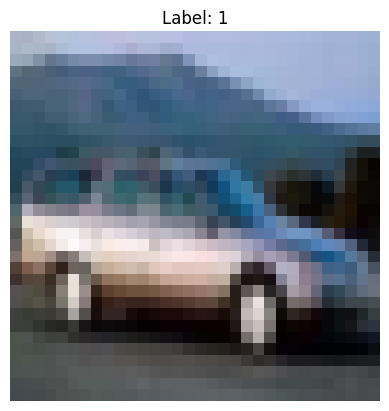

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[4]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[4][0]}')
plt.axis('off')
plt.show()
